<a href="https://colab.research.google.com/github/MilerDiazZevallos/Arequipa-Covid-19/blob/master/Sala_Situacional_Arequipa_SINADEF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialize Environment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from scipy.optimize import curve_fit
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib.cbook as cbook

# Load Data from SINADEF

In [2]:
import requests 

def download_url(url, save_path, chunk_size=128):
    r = requests.get(url, stream=True)
    with open(save_path, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=chunk_size):
            fd.write(chunk)

In [ ]:
# Excel with date
url_sinadef="SINADEF_DATOS_ABIERTOS_06042021.xlsx"
download_url("https://cloud.minsa.gob.pe/s/NctBnHXDnocgWAg/download?path=%2F&files="+url_sinadef, url_sinadef)
datos_sinadef_old = pd.read_excel(url_sinadef, sheet_name='Tabla_SINADEF', skiprows=range(3), skipfooter=0)
datos_sinadef_old.tail()

In [3]:
# CSV file (without date)
SINADEF_File="fallecidos_sinadef.csv"
download_url("https://cloud.minsa.gob.pe/s/nqF2irNbFomCLaa/download",SINADEF_File) 
datos_SINADEF = pd.read_csv(SINADEF_File, encoding = "ISO-8859-1", sep=";",skiprows=range(2), skipfooter=0)
datos_SINADEF.sort_values('FECHA').tail()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Nº TIPO SEGURO       SEXO  ... Unnamed: 32 Unnamed: 33 Unnamed: 34
685740  685741         SIS  MASCULINO  ...         NaN         NaN         NaN
685741  685742         SIS   FEMENINO  ...         NaN         NaN         NaN
685742  685743         SIS  MASCULINO  ...         NaN         NaN         NaN
685743  685744         SIS   FEMENINO  ...         NaN         NaN         NaN
685744  685745         SIS  MASCULINO  ...         NaN         NaN         NaN

[5 rows x 35 columns]

# Funciones Auxiliares

In [5]:
dia_semana_sinadef = '2021-05-30'
dia_sinadef = '2021-05-30'

In [6]:
def plots(ax, type, data, labelx, labely, datax = '', datay = '', label = ''):
    if type == 'bar_promLine_plt':
        #ax.bar(data.index, data[datay], edgecolor='k', width=1, label=labely)
        ax = sns.barplot(x=data[datax], y=datay, data=data, ax=ax)  
        ax.plot(data[datax].rolling(7).mean(),'-',ms=10,label=labely + ' promedio 7 días', color='k',linewidth=3)
        ax.tick_params(labelsize=16)
        ax.set_xlabel(labelx,fontsize=16)
   
    elif type == 'line_plt':
        ax.plot(data[datax],'o',ms=10,label=labely, color ='g')
        ax.plot(data[datax].rolling(7).mean(),'-',ms=10,label=labely + ' promedio 7 días', color='k',linewidth=3)
        ax.tick_params(labelsize=18)
        ax.set_xlabel(labelx,fontsize=20)
        #ax.set_xlim([pd.to_datetime('2020-11-01'),None])
    elif type == 'reg_sns':
        ax = sns.regplot(x=datax, y=datay, data=data, order=3, label=labely, ax=ax)
        ax.tick_params(labelsize=18)
        ax.set_xlabel(labelx,fontsize=28)
        ax.set_ylabel(labely,fontsize=28)
        #ax.set_xlim([pd.to_datetime('2020-09-01'),None])
    elif type == 'bar_sns':
        ax = sns.barplot(x=data.index, y=datay, data=data, ax=ax)
        ax.tick_params(labelsize=18)
        ax.set_xlabel(labelx,fontsize=28)
        ax.set_ylabel(labely,fontsize=28)
        #ax.set_xlim([pd.to_datetime('2020-09-01'),None])
    elif type == 'bar_stacked_plt':
        ax.bar(data.index, data[datay+'_positivos'], edgecolor='white', width=1, label=labely+' positivos')
        ax.bar(data.index, data[datay+'_sospechosos'], bottom=data[datay+'_positivos'], edgecolor='white', width=1, label=labely+' sospechosos')
        ax.tick_params(labelsize=18)
        ax.set_xlabel(labelx,fontsize=28)
        ax.set_ylabel(labely,fontsize=28)
        #ax.set_xlim([pd.to_datetime('2020-09-01'),None])
    elif type == 'bar_stacked_plt_uci':
        ax.bar(data.index, data[datay+'_positivos'], edgecolor='white', width=1, label=labely+' positivos')
        ax.bar(data.index, data[datay+'_sospechosos'], bottom=data[datay+'_positivos'], edgecolor='white', width=1, label=labely+' sospechosos')
        ax.bar(data.index, data['trauma_shock'], bottom=data[datay+'_positivos'] + data[datay+'_sospechosos'], edgecolor='white', width=1, label='trauma shock')
        ax.tick_params(labelsize=18)
        ax.set_xlabel(labelx,fontsize=28)
        ax.set_ylabel(labely,fontsize=28)
        #ax.set_xlim([pd.to_datetime('2020-09-01'),None])
    elif type == 'line_reg_stacked_sns':
        ax = sns.regplot(x=datax, y=datay+'_positivos', data=data, order=3, label=labely+' positivos', ax=ax)
        ax = sns.regplot(x=datax, y=datay+'_sospechosos', data=data, order=3, label=labely+' sospechosos', ax=ax)
        ax.tick_params(labelsize=18)
        ax.set_xlabel(labelx,fontsize=28)
        ax.set_ylabel(labely,fontsize=28)
        #ax.set_xlim([pd.to_datetime('2020-09-01'),None])
    ax.legend(fontsize=20)

# Pre-procesamiento

In [7]:
#datos_sinadef_old.sort_values('FECHA').tail()
datos_SINADEF.sort_values('FECHA').tail(10)

Nº TIPO SEGURO       SEXO  ... Unnamed: 32 Unnamed: 33 Unnamed: 34
242149  242150       OTROS  MASCULINO  ...         NaN         NaN         NaN
241707  241708     ESSALUD   FEMENINO  ...         NaN         NaN         NaN
242151  242152    IGNORADO   FEMENINO  ...         NaN         NaN         NaN
242154  242155     ESSALUD  MASCULINO  ...         NaN         NaN         NaN
242156  242157         SIS   FEMENINO  ...         NaN         NaN         NaN
242157  242158         SIS  MASCULINO  ...         NaN         NaN         NaN
241660  241661         SIS   FEMENINO  ...         NaN         NaN         NaN
242160  242161    PRIVADOS   FEMENINO  ...         NaN         NaN         NaN
242164  242165     ESSALUD  MASCULINO  ...         NaN         NaN         NaN
241816  241817         SIS   FEMENINO  ...         NaN         NaN         NaN

[10 rows x 35 columns]

In [8]:
#datos_sinadef_raw = datos_sinadef_old.copy()
datos_sinadef_raw = datos_SINADEF.copy()

In [9]:
datos_sinadef_raw['SEMANA'] = pd.to_datetime(datos_sinadef_raw['FECHA']).dt.week
datos_sinadef_raw['AÑOSEMANA'] = pd.to_datetime(datos_sinadef_raw['FECHA']).dt.strftime('%Y') + '-' + datos_sinadef_raw['SEMANA'].astype(str)
datos_sinadef_raw['MESDIA'] = pd.to_datetime(datos_sinadef_raw['FECHA']).dt.strftime('%m-%d')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """Entry point for launching an IPython kernel.


In [10]:
datos_sinadef_raw = datos_sinadef_raw[datos_sinadef_raw.FECHA >= '2018-01-01']
datos_sinadef_raw = datos_sinadef_raw[datos_sinadef_raw.FECHA <= dia_sinadef]

datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2018-12-31', 'AÑOSEMANA'] = '2019-1'

datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2019-12-30', 'AÑOSEMANA'] = '2020-1'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2019-12-31', 'AÑOSEMANA'] = '2020-1'

datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2020-12-28', 'AÑOSEMANA'] = '2021-1'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2020-12-29', 'AÑOSEMANA'] = '2021-1'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2020-12-30', 'AÑOSEMANA'] = '2021-1'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2020-12-31', 'AÑOSEMANA'] = '2021-1'

datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-01', 'AÑOSEMANA'] = '2021-1'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-02', 'AÑOSEMANA'] = '2021-1'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-03', 'AÑOSEMANA'] = '2021-1'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-04', 'AÑOSEMANA'] = '2021-2'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-05', 'AÑOSEMANA'] = '2021-2'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-06', 'AÑOSEMANA'] = '2021-2'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-07', 'AÑOSEMANA'] = '2021-2'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-08', 'AÑOSEMANA'] = '2021-2'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-09', 'AÑOSEMANA'] = '2021-2'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-10', 'AÑOSEMANA'] = '2021-2'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-11', 'AÑOSEMANA'] = '2021-3'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-12', 'AÑOSEMANA'] = '2021-3'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-13', 'AÑOSEMANA'] = '2021-3'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-14', 'AÑOSEMANA'] = '2021-3'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-15', 'AÑOSEMANA'] = '2021-3'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-16', 'AÑOSEMANA'] = '2021-3'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-17', 'AÑOSEMANA'] = '2021-3'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-18', 'AÑOSEMANA'] = '2021-4'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-19', 'AÑOSEMANA'] = '2021-4'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-20', 'AÑOSEMANA'] = '2021-4'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-21', 'AÑOSEMANA'] = '2021-4'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-22', 'AÑOSEMANA'] = '2021-4'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-23', 'AÑOSEMANA'] = '2021-4'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-24', 'AÑOSEMANA'] = '2021-4'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-25', 'AÑOSEMANA'] = '2021-5'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-26', 'AÑOSEMANA'] = '2021-5'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-27', 'AÑOSEMANA'] = '2021-5'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-28', 'AÑOSEMANA'] = '2021-5'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-29', 'AÑOSEMANA'] = '2021-5'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-30', 'AÑOSEMANA'] = '2021-5'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-01-31', 'AÑOSEMANA'] = '2021-5'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-02-01', 'AÑOSEMANA'] = '2021-6'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-02-02', 'AÑOSEMANA'] = '2021-6'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-02-03', 'AÑOSEMANA'] = '2021-6'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-02-04', 'AÑOSEMANA'] = '2021-6'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-02-05', 'AÑOSEMANA'] = '2021-6'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-02-06', 'AÑOSEMANA'] = '2021-6'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-02-07', 'AÑOSEMANA'] = '2021-6'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-02-08', 'AÑOSEMANA'] = '2021-7'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-02-09', 'AÑOSEMANA'] = '2021-7'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-02-10', 'AÑOSEMANA'] = '2021-7'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-02-11', 'AÑOSEMANA'] = '2021-7'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-02-12', 'AÑOSEMANA'] = '2021-7'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-02-13', 'AÑOSEMANA'] = '2021-7'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-02-14', 'AÑOSEMANA'] = '2021-7'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-02-15', 'AÑOSEMANA'] = '2021-8'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-02-16', 'AÑOSEMANA'] = '2021-8'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-02-17', 'AÑOSEMANA'] = '2021-8'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-02-18', 'AÑOSEMANA'] = '2021-8'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-02-19', 'AÑOSEMANA'] = '2021-8'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-02-20', 'AÑOSEMANA'] = '2021-8'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-02-21', 'AÑOSEMANA'] = '2021-8'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-02-22', 'AÑOSEMANA'] = '2021-9'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-02-23', 'AÑOSEMANA'] = '2021-9'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-02-24', 'AÑOSEMANA'] = '2021-9'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-02-25', 'AÑOSEMANA'] = '2021-9'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-02-26', 'AÑOSEMANA'] = '2021-9'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-02-27', 'AÑOSEMANA'] = '2021-9'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-02-28', 'AÑOSEMANA'] = '2021-9'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-03-01', 'AÑOSEMANA'] = '2021-10'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-03-02', 'AÑOSEMANA'] = '2021-10'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-03-03', 'AÑOSEMANA'] = '2021-10'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-03-04', 'AÑOSEMANA'] = '2021-10'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-03-05', 'AÑOSEMANA'] = '2021-10'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-03-06', 'AÑOSEMANA'] = '2021-10'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-03-07', 'AÑOSEMANA'] = '2021-10'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-03-08', 'AÑOSEMANA'] = '2021-11'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-03-09', 'AÑOSEMANA'] = '2021-11'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-03-10', 'AÑOSEMANA'] = '2021-11'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-03-11', 'AÑOSEMANA'] = '2021-11'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-03-12', 'AÑOSEMANA'] = '2021-11'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-03-13', 'AÑOSEMANA'] = '2021-11'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-03-14', 'AÑOSEMANA'] = '2021-11'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-03-15', 'AÑOSEMANA'] = '2021-12'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-03-16', 'AÑOSEMANA'] = '2021-12'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-03-17', 'AÑOSEMANA'] = '2021-12'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-03-18', 'AÑOSEMANA'] = '2021-12'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-03-19', 'AÑOSEMANA'] = '2021-12'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-03-20', 'AÑOSEMANA'] = '2021-12'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-03-21', 'AÑOSEMANA'] = '2021-12'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-03-22', 'AÑOSEMANA'] = '2021-13'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-03-23', 'AÑOSEMANA'] = '2021-13'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-03-24', 'AÑOSEMANA'] = '2021-13'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-03-25', 'AÑOSEMANA'] = '2021-13'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-03-26', 'AÑOSEMANA'] = '2021-13'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-03-27', 'AÑOSEMANA'] = '2021-13'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-03-28', 'AÑOSEMANA'] = '2021-13'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-03-29', 'AÑOSEMANA'] = '2021-14'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-03-30', 'AÑOSEMANA'] = '2021-14'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-03-31', 'AÑOSEMANA'] = '2021-14'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-04-01', 'AÑOSEMANA'] = '2021-14'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-04-02', 'AÑOSEMANA'] = '2021-14'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-04-03', 'AÑOSEMANA'] = '2021-14'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-04-04', 'AÑOSEMANA'] = '2021-14'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-04-05', 'AÑOSEMANA'] = '2021-15'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-04-06', 'AÑOSEMANA'] = '2021-15'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-04-07', 'AÑOSEMANA'] = '2021-15'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-04-08', 'AÑOSEMANA'] = '2021-15'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-04-09', 'AÑOSEMANA'] = '2021-15'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-04-10', 'AÑOSEMANA'] = '2021-15'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-04-11', 'AÑOSEMANA'] = '2021-15'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-04-12', 'AÑOSEMANA'] = '2021-16'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-04-13', 'AÑOSEMANA'] = '2021-16'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-04-14', 'AÑOSEMANA'] = '2021-16'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-04-15', 'AÑOSEMANA'] = '2021-16'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-04-16', 'AÑOSEMANA'] = '2021-16'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-04-17', 'AÑOSEMANA'] = '2021-16'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-04-18', 'AÑOSEMANA'] = '2021-16'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-04-19', 'AÑOSEMANA'] = '2021-17'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-04-20', 'AÑOSEMANA'] = '2021-17'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-04-21', 'AÑOSEMANA'] = '2021-17'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-04-22', 'AÑOSEMANA'] = '2021-17'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-04-23', 'AÑOSEMANA'] = '2021-17'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-04-24', 'AÑOSEMANA'] = '2021-17'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-04-25', 'AÑOSEMANA'] = '2021-17'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-04-26', 'AÑOSEMANA'] = '2021-18'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-04-27', 'AÑOSEMANA'] = '2021-18'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-04-28', 'AÑOSEMANA'] = '2021-18'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-04-29', 'AÑOSEMANA'] = '2021-18'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-04-30', 'AÑOSEMANA'] = '2021-18'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-05-01', 'AÑOSEMANA'] = '2021-18'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-05-02', 'AÑOSEMANA'] = '2021-18'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-05-03', 'AÑOSEMANA'] = '2021-19'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-05-04', 'AÑOSEMANA'] = '2021-19'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-05-05', 'AÑOSEMANA'] = '2021-19'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-05-06', 'AÑOSEMANA'] = '2021-19'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-05-07', 'AÑOSEMANA'] = '2021-19'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-05-08', 'AÑOSEMANA'] = '2021-19'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-05-09', 'AÑOSEMANA'] = '2021-19'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-05-10', 'AÑOSEMANA'] = '2021-20'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-05-11', 'AÑOSEMANA'] = '2021-20'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-05-12', 'AÑOSEMANA'] = '2021-20'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-05-13', 'AÑOSEMANA'] = '2021-20'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-05-14', 'AÑOSEMANA'] = '2021-20'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-05-15', 'AÑOSEMANA'] = '2021-20'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-05-16', 'AÑOSEMANA'] = '2021-20'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-05-17', 'AÑOSEMANA'] = '2021-21'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-05-18', 'AÑOSEMANA'] = '2021-21'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-05-19', 'AÑOSEMANA'] = '2021-21'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-05-20', 'AÑOSEMANA'] = '2021-21'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-05-21', 'AÑOSEMANA'] = '2021-21'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-05-22', 'AÑOSEMANA'] = '2021-21'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-05-23', 'AÑOSEMANA'] = '2021-21'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-05-24', 'AÑOSEMANA'] = '2021-22'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-05-25', 'AÑOSEMANA'] = '2021-22'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-05-26', 'AÑOSEMANA'] = '2021-22'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-05-27', 'AÑOSEMANA'] = '2021-22'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-05-28', 'AÑOSEMANA'] = '2021-22'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-05-29', 'AÑOSEMANA'] = '2021-22'
datos_sinadef_raw.loc[datos_sinadef_raw['FECHA'] == '2021-05-30', 'AÑOSEMANA'] = '2021-22'

In [11]:
new = datos_sinadef_raw["AÑOSEMANA"].str.split("-", n = 1, expand = True) 
datos_sinadef_raw["AÑO2"]= new[0].astype(int)
datos_sinadef_raw["SEMANA"]= new[1].astype(int)

# Visualizaciones Peru, Semanales y Diarias

In [12]:
datos_sinadef_semana = datos_sinadef_raw[datos_sinadef_raw['FECHA'] <= dia_semana_sinadef ]
datos_sinadef_semana = datos_sinadef_semana.groupby(['SEMANA', 'AÑO2'])['Nº'].count()
datos_sinadef_semana = datos_sinadef_semana.to_frame().reset_index()
datos_sinadef_semana.sort_values(['AÑO2', 'SEMANA'])

SEMANA  AÑO2    Nº
0        1  2018  1988
4        2  2018  1980
8        3  2018  1922
12       4  2018  1953
16       5  2018  1888
..     ...   ...   ...
71      18  2021  7583
75      19  2021  7056
79      20  2021  6421
83      21  2021  5886
87      22  2021  4955

[178 rows x 3 columns]

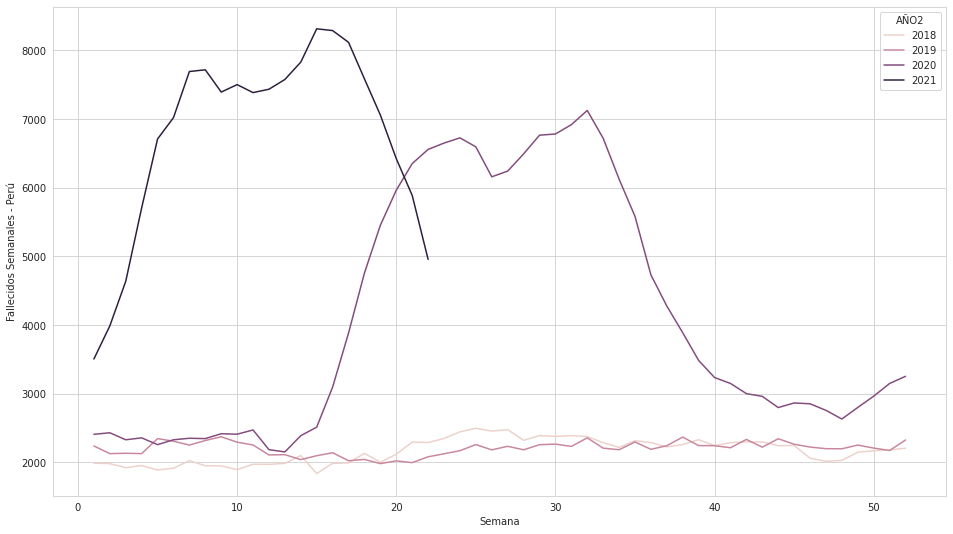

In [13]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
colorsTable = ['cyan','green','blue']
sns.lineplot(data=datos_sinadef_semana, x = 'SEMANA', y = 'Nº', hue='AÑO2', color='r',ax=ax1)
#sns.lineplot(data=datos_sinadef_semana, x = 'SEMANA', y = 'Nº', color='r',ax=ax1)

plt.xlabel('Semana')
plt.ylabel('Fallecidos Semanales - Perú')
plt.savefig('SINADEF_VariosAnios.pdf')
#fig.tight_layout()

plt.show()

In [14]:
datos_sinadef_dia = datos_sinadef_raw[datos_sinadef_raw['FECHA'] <= dia_sinadef ]
datos_sinadef_dia = datos_sinadef_dia.groupby(['MESDIA', 'AÑO'])['Nº'].count()
datos_sinadef_dia = datos_sinadef_dia.to_frame().reset_index()

datos_sinadef_dia

MESDIA   AÑO   Nº
0     01-01  2018  322
1     01-01  2019  345
2     01-01  2020  378
3     01-01  2021  517
4     01-02  2018  298
...     ...   ...  ...
1241  12-30  2019  341
1242  12-30  2020  501
1243  12-31  2018  296
1244  12-31  2019  338
1245  12-31  2020  478

[1246 rows x 3 columns]

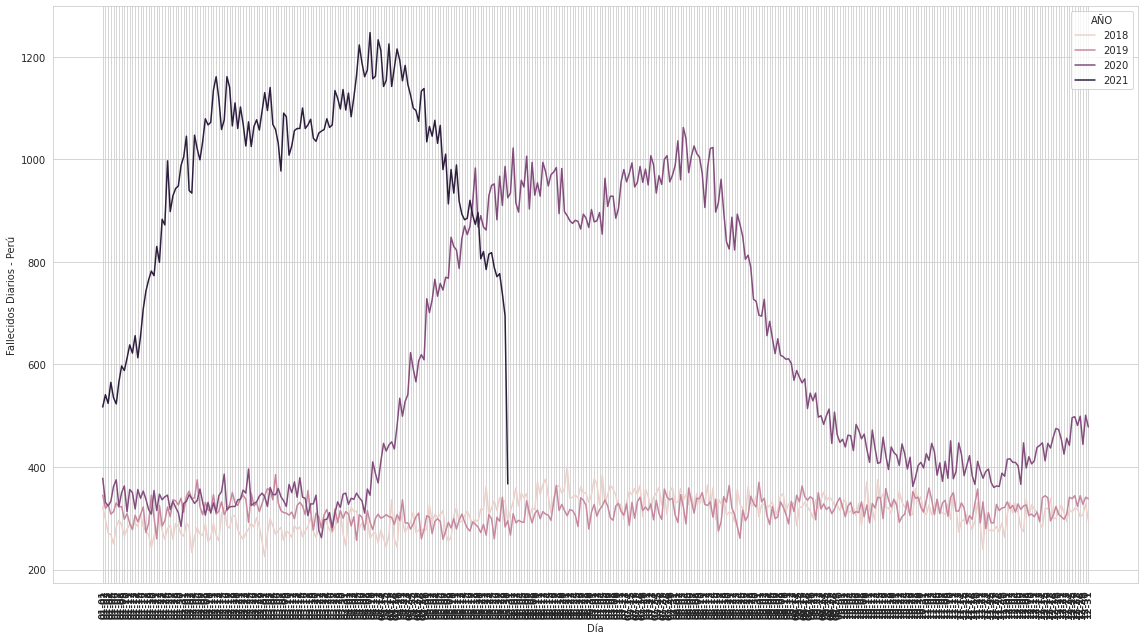

In [15]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))

sns.lineplot(data=datos_sinadef_dia, x = 'MESDIA', y = 'Nº', hue='AÑO', ax=ax1)
#ax1.xaxis_date()

plt.xlabel('Día')
plt.ylabel('Fallecidos Diarios - Perú')
plt.xticks(rotation=90, fontsize=9, fontweight='bold')
fig.tight_layout()

plt.savefig('SINADEF_Anual.pdf')
plt.show()

In [16]:
datos_sinadef_departamentos = datos_sinadef_raw[datos_sinadef_raw['FECHA'] <= dia_semana_sinadef ]
datos_sinadef_departamentos = datos_sinadef_departamentos.groupby(['DEPARTAMENTO DOMICILIO', 'AÑO2', 'SEMANA'])['Nº'].count()
datos_sinadef_departamentos = datos_sinadef_departamentos.to_frame()
datos_sinadef_departamentos.columns = ['real']
datos_sinadef_departamentos

real
DEPARTAMENTO DOMICILIO AÑO2 SEMANA      
AMAZONAS               2018 1         13
                            2         20
                            3         12
                            4         21
                            5         27
...                                  ...
UCAYALI                2021 18        90
                            19        75
                            20        61
                            21        65
                            22        50

[4798 rows x 1 columns]

In [17]:
def plot_sinadef_departamentos(result, ax, state_name):
    ax.set_title(f"{state_name}")

    #index = pd.to_datetime(result['real'].index.get_level_values('SEMANA'))
    index = result['real'].index.get_level_values('SEMANA')
    
    #sns.lineplot(data=result, x = index , y = 'real', hue=result['real'].index.get_level_values('FECHA'), ax=ax)
    sns.lineplot(data=result, x = index , y = 'real', hue=result['real'].index.get_level_values('AÑO2'), ax=ax)
    #sns.lineplot(data=result, x = index , y = 'real', ax=ax)

def plot_rt_states():
    N_COLS = 2
    N_ROWS = int(np.ceil(len(datos_sinadef_raw['DEPARTAMENTO DOMICILIO'].unique()) / N_COLS))

    fig, axes = plt.subplots(nrows=N_ROWS, ncols=N_COLS, figsize=(24, N_ROWS*3), dpi=90)
    
    # loop for several states
    for i, (state_name, result) in enumerate(datos_sinadef_departamentos.groupby('DEPARTAMENTO DOMICILIO')):
        plot_sinadef_departamentos(result, axes.flat[i], state_name)

    # saving figure
    fig.tight_layout()
    fig.set_facecolor('w')

    plt.savefig('SINADEF_COVID_Regiones_01.pdf')

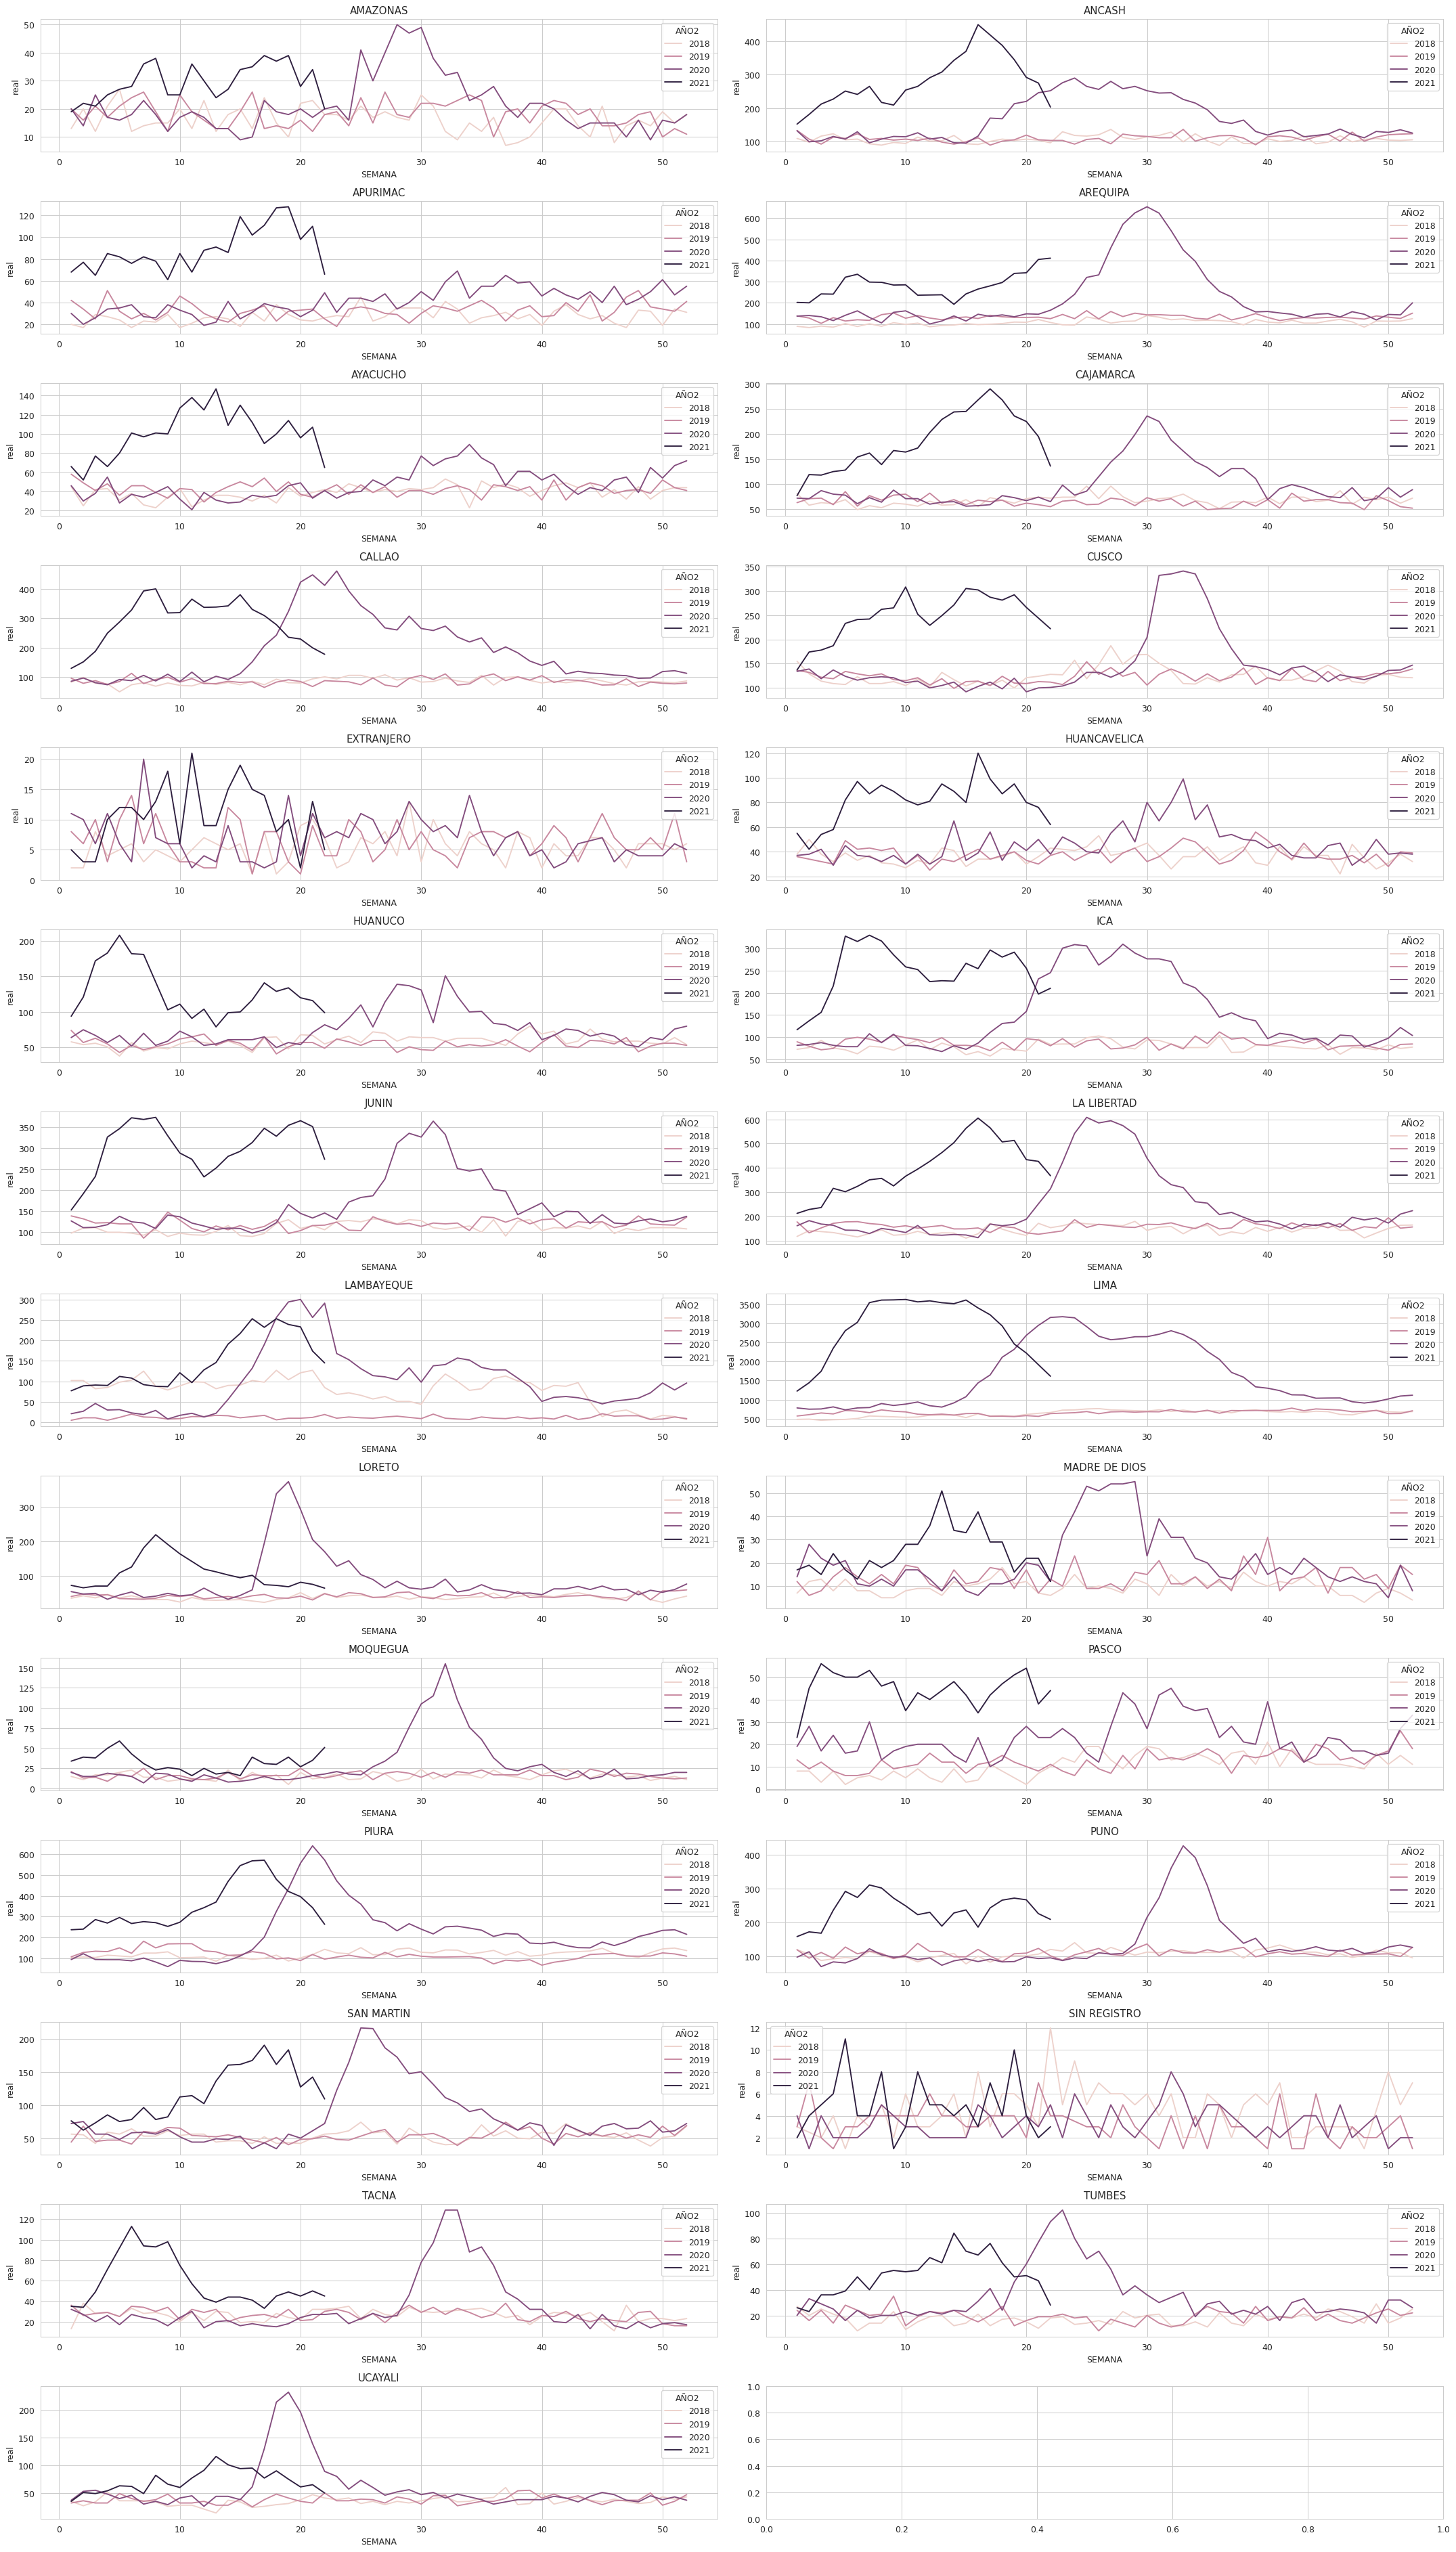

In [18]:
plot_rt_states()

# Fallecidos diarios todas las regiones
De 01/2020 hasta ahora

In [19]:
datos_sinadef_pandemia = datos_sinadef_raw[datos_sinadef_raw['FECHA'] >= '2020-01-01']
datos_sinadef_pandemia.info()

def plot_sinadef_regiones(result, ax, state_name):
    ax.set_title(f"{state_name}")

    #index = pd.to_datetime(result['real'].index.get_level_values('SEMANA'))
    index = result['real'].index.get_level_values('FECHA')
    
    sns.lineplot(data=result, x = index , y = 'real', hue=result['real'].index.get_level_values('FECHA'), ax=ax)
    #sns.lineplot(data=result, x = index , y = 'real', ax=ax)

def plot_SINADEF_regions():
    N_COLS = 2
    N_ROWS = int(np.ceil(len(datos_sinadef_pandemia['DEPARTAMENTO DOMICILIO'].unique()) / N_COLS))

    fig, axes = plt.subplots(nrows=N_ROWS, ncols=N_COLS, figsize=(24, N_ROWS*3), dpi=90)
    
    # loop for several states
    for i, (state_name, result) in enumerate(datos_sinadef_pandemia.groupby('DEPARTAMENTO DOMICILIO')):
        plot_sinadef_regiones(result, axes.flat[i], state_name)

    # saving figure
    fig.tight_layout()
    fig.set_facecolor('w')

    plt.savefig('SINADEF_COVID_Diario_Regiones.pdf')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359017 entries, 0 to 685744
Data columns (total 39 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Nº                      359017 non-null  int64  
 1   TIPO SEGURO             359017 non-null  object 
 2   SEXO                    359017 non-null  object 
 3   EDAD                    359017 non-null  object 
 4   TIEMPO EDAD             359017 non-null  object 
 5   ESTADO CIVIL            359017 non-null  object 
 6   NIVEL DE INSTRUCCIÓN    359017 non-null  object 
 7   COD# UBIGEO DOMICILIO   359017 non-null  object 
 8   PAIS DOMICILIO          359017 non-null  object 
 9   DEPARTAMENTO DOMICILIO  359017 non-null  object 
 10  PROVINCIA DOMICILIO     359017 non-null  object 
 11  DISTRITO DOMICILIO      359017 non-null  object 
 12  FECHA                   359017 non-null  object 
 13  AÑO                     359017 non-null  int64  
 14  MES                 

KeyError: ignored

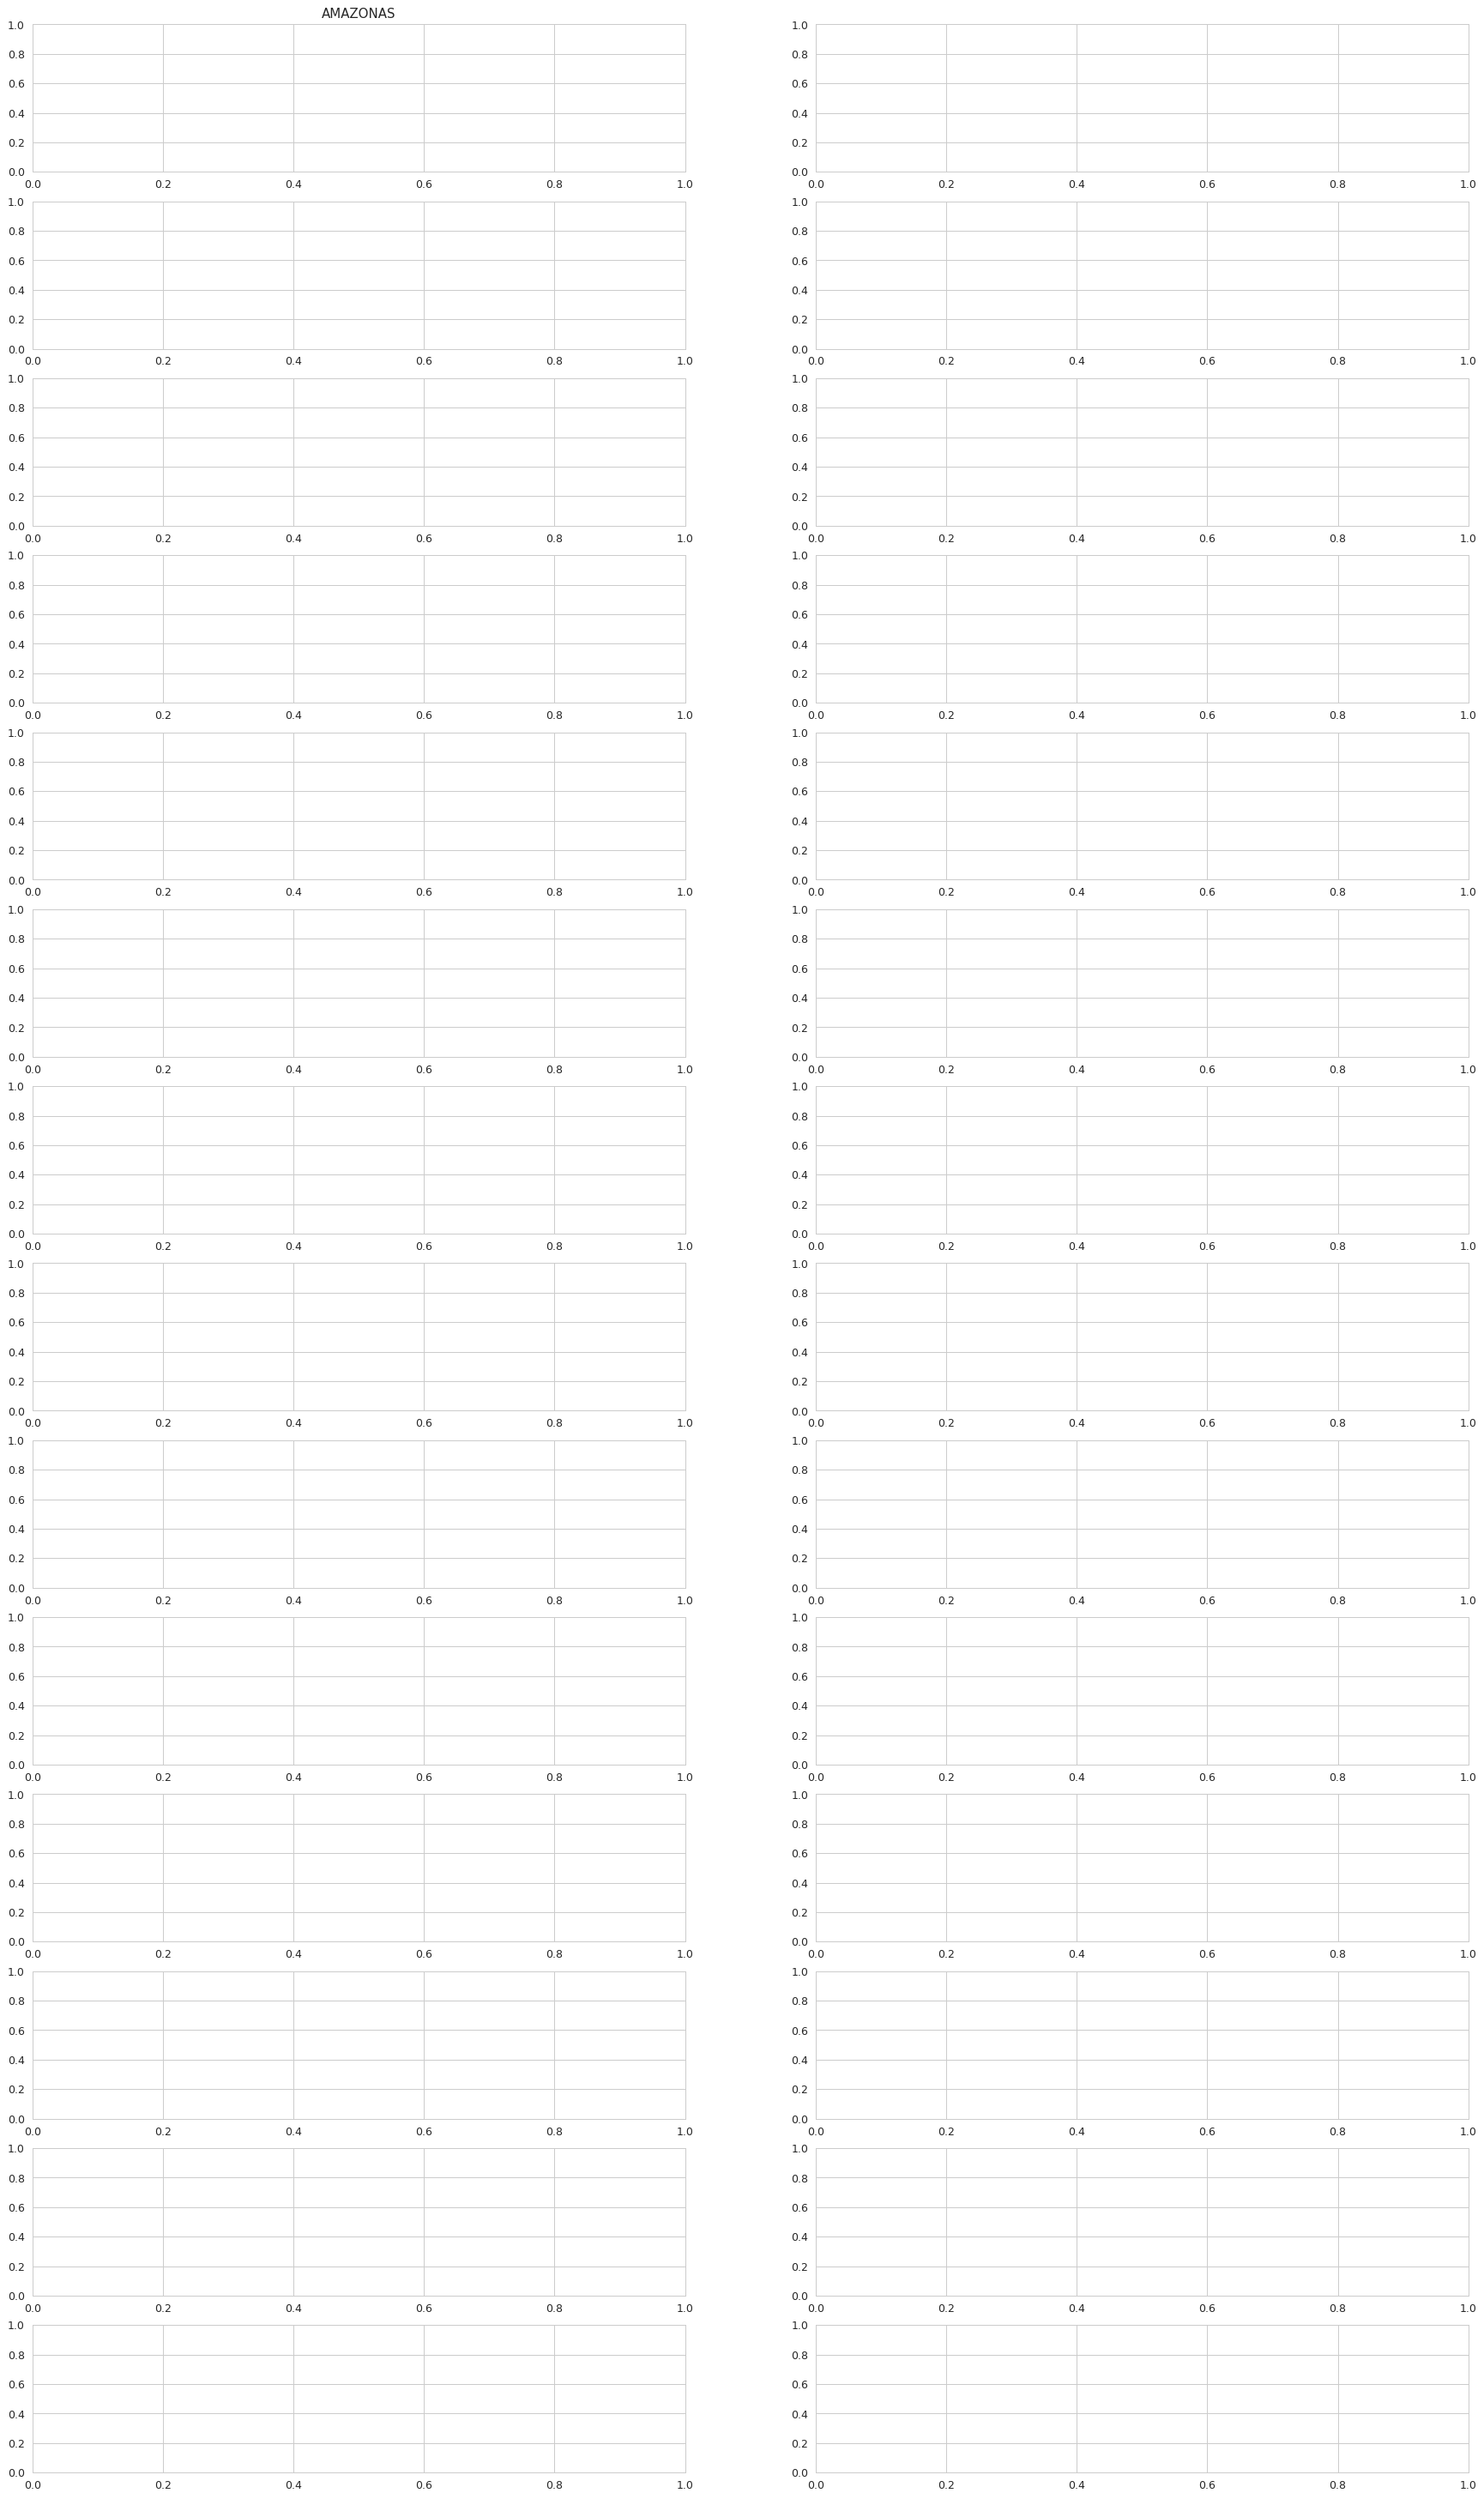

In [20]:
plot_SINADEF_regions()

# Visualizaciones Arequipa, Semanales

In [21]:
datos_sinadef_no_violenta_semana = datos_sinadef_raw[datos_sinadef_raw['FECHA'] <= dia_semana_sinadef ]
#datos_sinadef_no_violenta_semana = datos_sinadef_no_violenta_semana[(datos_sinadef_no_violenta_semana['MUERTE VIOLENTA'] == 'SIN REGISTRO')]

datos_sinadef_arequipa = datos_sinadef_no_violenta_semana[datos_sinadef_no_violenta_semana['DEPARTAMENTO DOMICILIO'] == 'AREQUIPA']
datos_sinadef_arequipa['DIASEMANA'] = pd.to_datetime(datos_sinadef_arequipa['FECHA']).dt.weekday
datos_sinadef_arequipa = datos_sinadef_arequipa.reset_index(drop=True)
datos_sinadef_arequipa.tail()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Nº TIPO SEGURO       SEXO EDAD  ... AÑOSEMANA MESDIA  AÑO2 DIASEMANA
30116  685355     ESSALUD  MASCULINO   94  ...   2020-49  12-02  2020         2
30117  685378     ESSALUD   FEMENINO   85  ...   2020-49  12-02  2020         2
30118  685391         SIS   FEMENINO   67  ...   2020-49  12-01  2020         1
30119  685401     ESSALUD  MASCULINO   84  ...   2020-49  12-01  2020         1
30120  685599         SIS   FEMENINO   58  ...   2020-50  12-13  2020         6

[5 rows x 40 columns]

In [22]:
datos_sinadef_arequipa_semana = datos_sinadef_arequipa.groupby(['SEMANA', 'AÑO2'])['Nº'].count()
datos_sinadef_arequipa_semana = datos_sinadef_arequipa_semana.to_frame().reset_index()
datos_sinadef_arequipa_semana.tail()

SEMANA  AÑO2   Nº
173      51  2019  126
174      51  2020  143
175      52  2018  125
176      52  2019  151
177      52  2020  200

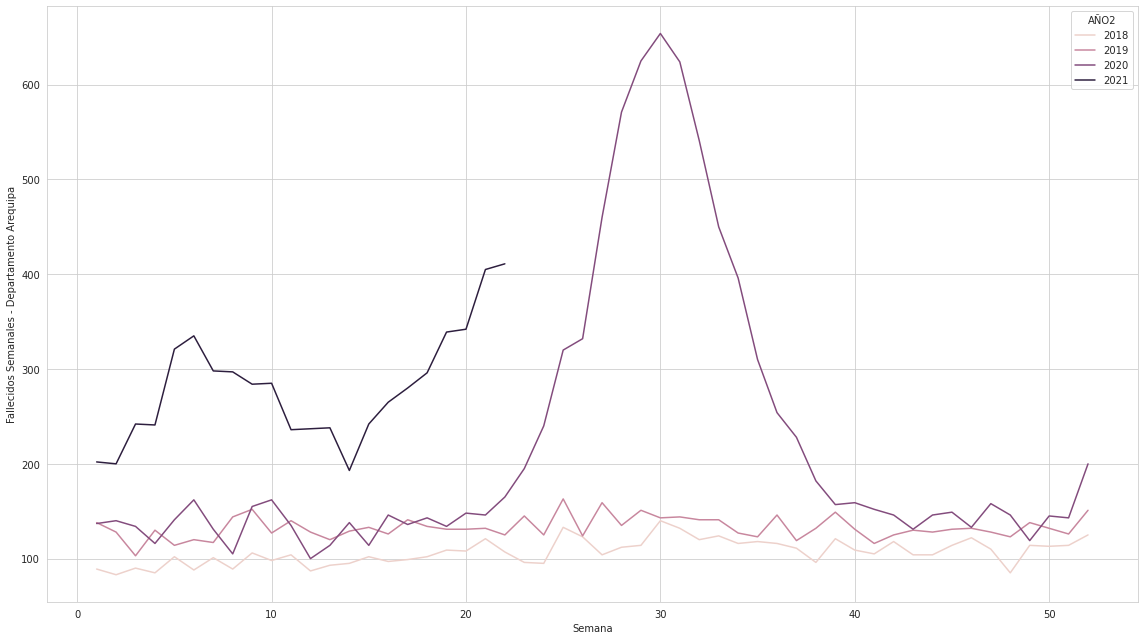

In [23]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))

sns.lineplot(data=datos_sinadef_arequipa_semana, x = 'SEMANA', y = 'Nº', hue='AÑO2', ax=ax1)

plt.xlabel('Semana')
plt.ylabel('Fallecidos Semanales - Departamento Arequipa')
fig.tight_layout()

plt.show()

# Datos No Violentos

In [24]:
datos_sinadef_no_violenta_diaria = datos_sinadef_raw[(datos_sinadef_raw['MUERTE VIOLENTA'] == 'SIN REGISTRO')]

# Perú sólo COVID

In [25]:
# Datos toda causa no violenta
datos_sinadef_no_violenta_Peru = datos_sinadef_no_violenta_diaria[(datos_sinadef_no_violenta_diaria['FECHA'] >= '2020-01-01')]
# Datos COVID U071
datos_sinadef_no_violenta_Peru_COVID = datos_sinadef_no_violenta_diaria[(datos_sinadef_no_violenta_diaria['FECHA'] >= '2020-01-01')]
datos_sinadef_no_violenta_Peru_COVID = datos_sinadef_no_violenta_Peru_COVID[(datos_sinadef_no_violenta_Peru_COVID['CAUSA A (CIE-X)'] == 'U071') | (datos_sinadef_no_violenta_Peru_COVID['CAUSA B (CIE-X)'] == 'U071') | (datos_sinadef_no_violenta_Peru_COVID['CAUSA C (CIE-X)'] == 'U071') | (datos_sinadef_no_violenta_Peru_COVID['CAUSA D (CIE-X)'] == 'U071') | (datos_sinadef_no_violenta_Peru_COVID['CAUSA E (CIE-X)'] == 'U071') | (datos_sinadef_no_violenta_Peru_COVID['CAUSA F (CIE-X)'] == 'U071')]


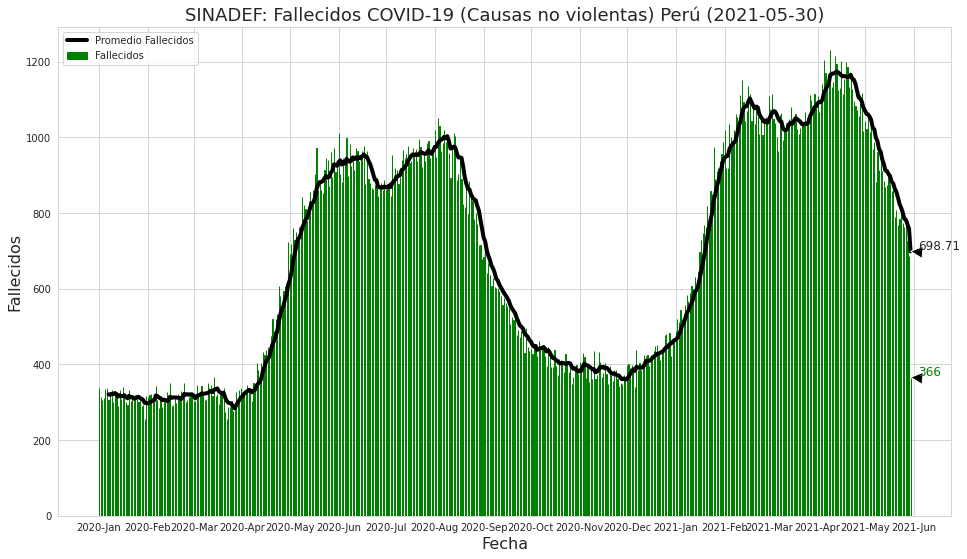

In [26]:
datos_sinadef_no_violenta_Peru_diaria = datos_sinadef_no_violenta_Peru.groupby(['FECHA'])['Nº'].count()
datos_sinadef_no_violenta_Peru_diaria = datos_sinadef_no_violenta_Peru_diaria.to_frame().reset_index()

datos_sinadef_no_violenta_Peru_diaria_aux0 = datos_sinadef_no_violenta_Peru_diaria
datos_sinadef_no_violenta_Peru_diaria_aux0['FECHA'] = pd.to_datetime(datos_sinadef_no_violenta_Peru_diaria_aux0['FECHA'])
datos_sinadef_no_violenta_Peru_diaria_aux0 = datos_sinadef_no_violenta_Peru_diaria_aux0.set_index('FECHA')
datos_sinadef_no_violenta_Peru_diaria_aux0['PromFallecidos'] = datos_sinadef_no_violenta_Peru_diaria_aux0['Nº'].rolling(window=7).mean() 
datos_sinadef_no_violenta_Peru_diaria_aux0.to_csv('SINADEF_NoViolento_Peru.csv')
barWidth = 0.10
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
ax1.bar(datos_sinadef_no_violenta_Peru_diaria_aux0.index,datos_sinadef_no_violenta_Peru_diaria_aux0['Nº'],color='g',edgecolor='g',width = barWidth, label='Fallecidos')
sns.lineplot(data=datos_sinadef_no_violenta_Peru_diaria_aux0, x=datos_sinadef_no_violenta_Peru_diaria_aux0.index, y="PromFallecidos", label='Promedio Fallecidos',  ax=ax1,color='k',linewidth=4.0)
# Format dates in xAxis
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
date_form = DateFormatter("%Y-%b")
ax1.xaxis.set_major_formatter(date_form)
# Add labels to the plot
lastDailyDead  = str(int(datos_sinadef_no_violenta_Peru_diaria_aux0.tail(1)['Nº']))
lastAverageDead = str(round(float(datos_sinadef_no_violenta_Peru_diaria_aux0.tail(1)['PromFallecidos']),2))
ax1.annotate(lastDailyDead, xy=(pd.to_datetime(dia_sinadef), datos_sinadef_no_violenta_Peru_diaria_aux0.tail(1)['Nº']),  xycoords='data',color='green',
            xytext=(pd.to_datetime('2021-06-04'), datos_sinadef_no_violenta_Peru_diaria_aux0.tail(1)['Nº']+6), textcoords='data',arrowprops=dict(facecolor='black', shrink=0.01),fontsize=12)
ax1.annotate(lastAverageDead, xy=(pd.to_datetime(dia_sinadef), datos_sinadef_no_violenta_Peru_diaria_aux0.tail(1)['PromFallecidos']),  xycoords='data',
            xytext=(pd.to_datetime('2021-06-04'), datos_sinadef_no_violenta_Peru_diaria_aux0.tail(1)['PromFallecidos']+6), textcoords='data',arrowprops=dict(facecolor='black', shrink=0.01),fontsize=12)

ax1.set_ylabel('Fallecidos', fontsize=16)
ax1.set_xlabel('Fecha', fontsize=16)
plt.title('SINADEF: Fallecidos COVID-19 (Causas no violentas) Perú ('+dia_sinadef+')',fontsize=18)
plt.savefig('SINADEF_NO_VIOLENTAS_Peru.pdf')


Peru COVID Diario

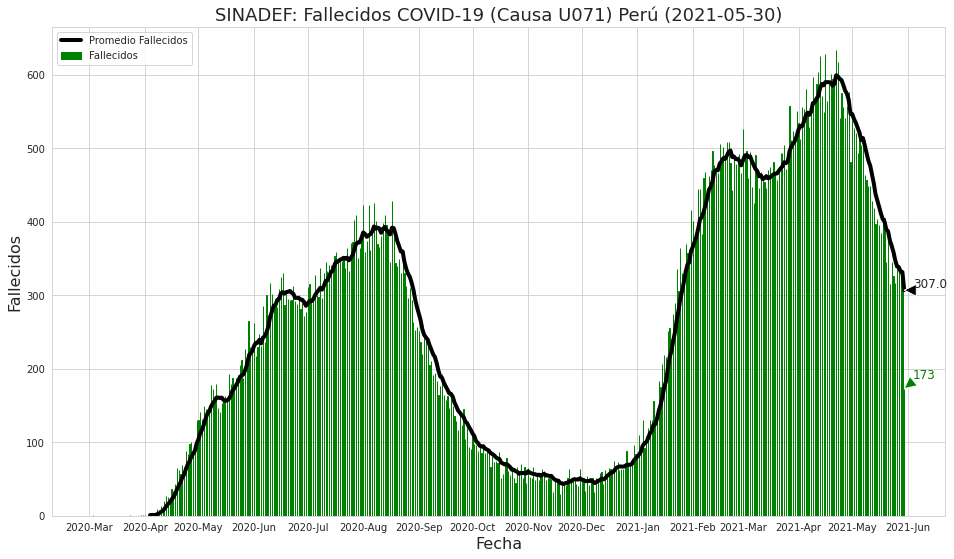

In [27]:
datos_sinadef_no_violenta_Peru_COVID_diaria = datos_sinadef_no_violenta_Peru_COVID.groupby(['FECHA'])['Nº'].count()
datos_sinadef_no_violenta_Peru_COVID_diaria = datos_sinadef_no_violenta_Peru_COVID_diaria.to_frame().reset_index()

datos_sinadef_no_violenta_Peru_COVID_diaria_aux1 = datos_sinadef_no_violenta_Peru_COVID_diaria
datos_sinadef_no_violenta_Peru_COVID_diaria_aux1['FECHA'] = pd.to_datetime(datos_sinadef_no_violenta_Peru_COVID_diaria_aux1['FECHA'])
datos_sinadef_no_violenta_Peru_COVID_diaria_aux1 = datos_sinadef_no_violenta_Peru_COVID_diaria_aux1.set_index('FECHA')
datos_sinadef_no_violenta_Peru_COVID_diaria_aux1['PromFallecidos'] = datos_sinadef_no_violenta_Peru_COVID_diaria_aux1['Nº'].rolling(window=7).mean() 
datos_sinadef_no_violenta_Peru_COVID_diaria_aux1.to_csv('SINADEF_COVID-19_Peru.csv')

barWidth = 0.10
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
ax1.bar(datos_sinadef_no_violenta_Peru_COVID_diaria_aux1.index,datos_sinadef_no_violenta_Peru_COVID_diaria_aux1['Nº'],color='g',edgecolor='g',width = barWidth, label='Fallecidos')
sns.lineplot(data=datos_sinadef_no_violenta_Peru_COVID_diaria_aux1, x=datos_sinadef_no_violenta_Peru_COVID_diaria_aux1.index, y="PromFallecidos", label='Promedio Fallecidos',  ax=ax1,color='k',linewidth=4.0)

# Format dates in xAxis
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
date_form = DateFormatter("%Y-%b")
ax1.xaxis.set_major_formatter(date_form)
# Add labels to the plot
lastDailyDead  = str(int(datos_sinadef_no_violenta_Peru_COVID_diaria_aux1.tail(1)['Nº']))
lastAverageDead = str(round(float(datos_sinadef_no_violenta_Peru_COVID_diaria_aux1.tail(1)['PromFallecidos']),2))
ax1.annotate(lastDailyDead, xy=(pd.to_datetime(dia_sinadef), datos_sinadef_no_violenta_Peru_COVID_diaria_aux1.tail(1)['Nº']),  xycoords='data',
            xytext=(pd.to_datetime('2021-06-04'), datos_sinadef_no_violenta_Peru_COVID_diaria_aux1.tail(1)['Nº']+14), textcoords='data',color='green',arrowprops=dict(facecolor='green', shrink=0.01),fontsize=12)
ax1.annotate(lastAverageDead, xy=(pd.to_datetime(dia_sinadef), datos_sinadef_no_violenta_Peru_COVID_diaria_aux1.tail(1)['PromFallecidos']),  xycoords='data',
            xytext=(pd.to_datetime('2021-06-04'), datos_sinadef_no_violenta_Peru_COVID_diaria_aux1.tail(1)['PromFallecidos']+4), textcoords='data',arrowprops=dict(facecolor='black', shrink=0.01),fontsize=12)

ax1.set_ylabel('Fallecidos', fontsize=16)
ax1.set_xlabel('Fecha', fontsize=16)
plt.title('SINADEF: Fallecidos COVID-19 (Causa U071) Perú ('+dia_sinadef+')',fontsize=18)
plt.savefig('SINADEF_COVID-19_Peru.pdf')

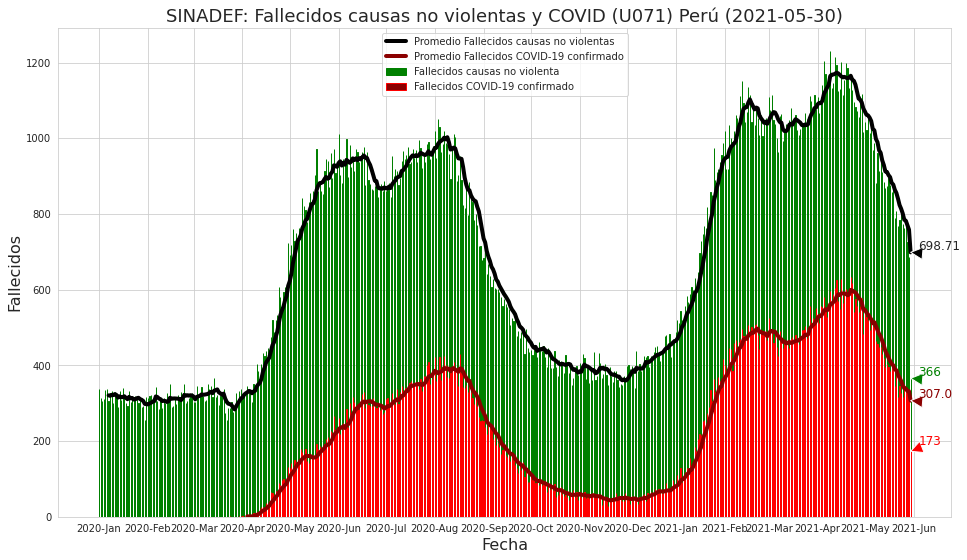

In [28]:
# Peru no Violento + COVID
datos_sinadef_no_violenta_Peru_diaria_aux0['COVID-19'] = datos_sinadef_no_violenta_Peru_COVID_diaria_aux1['Nº']
datos_sinadef_no_violenta_Peru_diaria_aux0['PromCOVID-19'] = datos_sinadef_no_violenta_Peru_COVID_diaria_aux1['PromFallecidos']

barWidth = 0.10
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
ax1.bar(datos_sinadef_no_violenta_Peru_diaria_aux0.index,datos_sinadef_no_violenta_Peru_diaria_aux0['Nº'],color='green',edgecolor='green',width = barWidth, label='Fallecidos causas no violenta')
sns.lineplot(data=datos_sinadef_no_violenta_Peru_diaria_aux0, x=datos_sinadef_no_violenta_Peru_diaria_aux0.index, y="PromFallecidos", label='Promedio Fallecidos causas no violentas',  ax=ax1,color='k',linewidth=4.0)
ax1.bar(datos_sinadef_no_violenta_Peru_diaria_aux0.index,datos_sinadef_no_violenta_Peru_diaria_aux0['COVID-19'],color='darkred',edgecolor='red',width = barWidth, label='Fallecidos COVID-19 confirmado')
sns.lineplot(data=datos_sinadef_no_violenta_Peru_diaria_aux0, x=datos_sinadef_no_violenta_Peru_diaria_aux0.index, y="PromCOVID-19", label='Promedio Fallecidos COVID-19 confirmado',  ax=ax1,color='darkred',linewidth=4.0)

# Format dates in xAxis
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
date_form = DateFormatter("%Y-%b")
ax1.xaxis.set_major_formatter(date_form)
# Add labels to the plot
lastDailyDead  = str(int(datos_sinadef_no_violenta_Peru_diaria_aux0.tail(1)['Nº']))
lastAverageDead = str(round(float(datos_sinadef_no_violenta_Peru_diaria_aux0.tail(1)['PromFallecidos']),2))
ax1.annotate(lastDailyDead, xy=(pd.to_datetime(dia_sinadef), datos_sinadef_no_violenta_Peru_diaria_aux0.tail(1)['Nº']),  xycoords='data',
            xytext=(pd.to_datetime('2021-06-04'), datos_sinadef_no_violenta_Peru_diaria_aux0.tail(1)['Nº']+6), textcoords='data',color='green',arrowprops=dict(facecolor='green', shrink=0.01),fontsize=12)
ax1.annotate(lastAverageDead, xy=(pd.to_datetime(dia_sinadef), datos_sinadef_no_violenta_Peru_diaria_aux0.tail(1)['PromFallecidos']),  xycoords='data',
            xytext=(pd.to_datetime('2021-06-04'), datos_sinadef_no_violenta_Peru_diaria_aux0.tail(1)['PromFallecidos']+6), textcoords='data',arrowprops=dict(facecolor='black', shrink=0.01),fontsize=12)

lastCOVIDDailyDead  = str(int(datos_sinadef_no_violenta_Peru_diaria_aux0.tail(1)['COVID-19']))
lastCOVIDAverageDead = str(round(float(datos_sinadef_no_violenta_Peru_diaria_aux0.tail(1)['PromCOVID-19']),2))

ax1.annotate(lastCOVIDDailyDead, xy=(pd.to_datetime(dia_sinadef), datos_sinadef_no_violenta_Peru_diaria_aux0.tail(1)['COVID-19']),  xycoords='data',
            xytext=(pd.to_datetime('2021-06-04'), datos_sinadef_no_violenta_Peru_diaria_aux0.tail(1)['COVID-19']+16), textcoords='data',color='r',arrowprops=dict(facecolor='r', shrink=0.01),fontsize=12)
ax1.annotate(lastCOVIDAverageDead, xy=(pd.to_datetime(dia_sinadef), datos_sinadef_no_violenta_Peru_diaria_aux0.tail(1)['PromCOVID-19']),  xycoords='data',
            xytext=(pd.to_datetime('2021-06-04'), datos_sinadef_no_violenta_Peru_diaria_aux0.tail(1)['PromCOVID-19']+6), textcoords='data',color='darkred',arrowprops=dict(facecolor='darkred', shrink=0.01),fontsize=12)

ax1.set_ylabel('Fallecidos', fontsize=16)
ax1.set_xlabel('Fecha', fontsize=16)
plt.title('SINADEF: Fallecidos causas no violentas y COVID (U071) Perú ('+dia_sinadef+')',fontsize=18)
plt.savefig('SINADEF_NoViolenta_COVID-19_Peru.pdf')


# Visualizaciones Arequipa

 # Arequipa no violento

In [29]:
datos_sinadef_arequipa = datos_sinadef_no_violenta_diaria[(datos_sinadef_no_violenta_diaria['FECHA'] >= '2020-01-1') & \
                                                                     (datos_sinadef_no_violenta_diaria['DEPARTAMENTO DOMICILIO'] == 'AREQUIPA')]
datos_sinadef_arequipa['FECHA'] = pd.to_datetime(datos_sinadef_arequipa['FECHA'])

datos_sinadef_arequipa_diaria = datos_sinadef_arequipa.groupby(['FECHA'])['Nº'].count()
datos_sinadef_arequipa_diaria = datos_sinadef_arequipa_diaria.to_frame().reset_index()
datos_sinadef_arequipa_diaria['PromFallecidos'] = datos_sinadef_arequipa_diaria['Nº'].rolling(window=7).mean() 
datos_sinadef_arequipa_diaria = datos_sinadef_arequipa_diaria.set_index('FECHA')
datos_sinadef_arequipa_diaria.to_csv('SINADEF_NoViolento_Arequipa.csv')
datos_sinadef_arequipa_diaria.tail(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Nº  PromFallecidos
FECHA                         
2021-05-26  57       56.714286
2021-05-27  65       57.857143
2021-05-28  65       58.857143
2021-05-29  64       59.714286
2021-05-30  44       57.428571

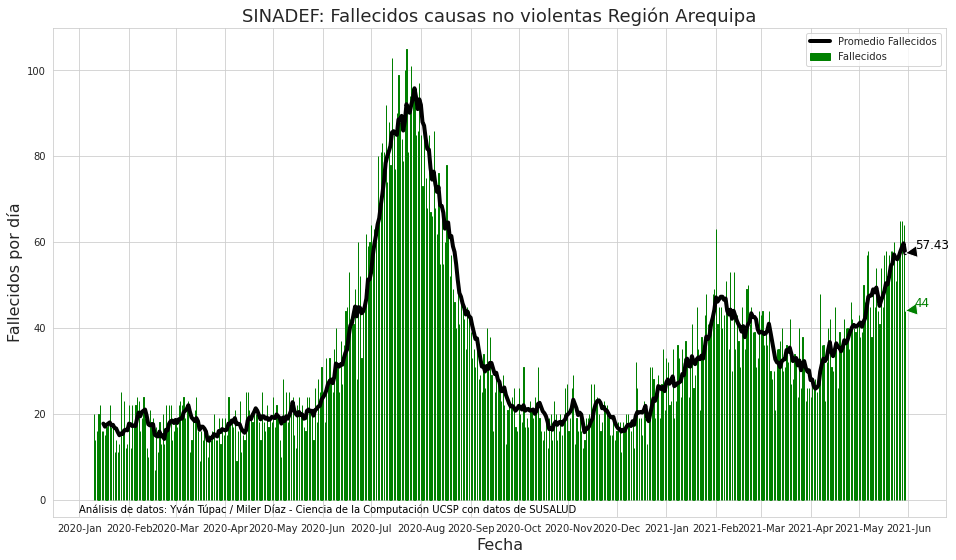

In [30]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
barWidth = 0.10
ax1.bar(datos_sinadef_arequipa_diaria.index,datos_sinadef_arequipa_diaria['Nº'],color='g',edgecolor='g',width = barWidth,label='Fallecidos')
sns.lineplot(data=datos_sinadef_arequipa_diaria, x=datos_sinadef_arequipa_diaria.index, y="PromFallecidos", label='Promedio Fallecidos',  ax=ax1,color='k',linewidth=4.0)
ax1.set_ylabel('Fallecidos por día', fontsize=16)
ax1.set_xlabel('Fecha', fontsize=16)
ax1.set_ylim(-4,110)
ax1.xaxis_date()

# Format dates in xAxis
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
date_form = DateFormatter("%Y-%b")
ax1.xaxis.set_major_formatter(date_form)
# Add anottations to the plot
style = dict(size=10, color='k')
ax1.text(pd.to_datetime('2020-01-1'), -3, "Análisis de datos: Yván Túpac / Miler Díaz - Ciencia de la Computación UCSP con datos de SUSALUD", **style)
#ax1.annotate("Pico 1a ola (38)\n2020-07-26", xy=(pd.to_datetime('2020-7-26'), 38),  xycoords='data',
#            xytext=(pd.to_datetime('2020-6-1'), 40), textcoords='data',arrowprops=dict(facecolor='black', shrink=0.01),fontsize=12)
#ax1.annotate("Pico 2a ola (28)\n2021-02-07", xy=(pd.to_datetime('2021-02-07'), 28),  xycoords='data',
#            xytext=(pd.to_datetime('2020-12-15'), 30), textcoords='data',arrowprops=dict(facecolor='black', shrink=0.01),fontsize=12)
lastDailyDead  = str(int(datos_sinadef_arequipa_diaria.tail(1)['Nº']))
lastPromDailyDead  = str(round(float(datos_sinadef_arequipa_diaria.tail(1)['PromFallecidos']),2))

ax1.annotate(lastPromDailyDead, xy=(pd.to_datetime(dia_sinadef), datos_sinadef_arequipa_diaria.tail(1)['PromFallecidos']),  xycoords='data',
            xytext=(pd.to_datetime('2021-06-05'), datos_sinadef_arequipa_diaria.tail(1)['PromFallecidos']+1), textcoords='data',color='k',arrowprops=dict(facecolor='k', shrink=0.01),fontsize=12)
ax1.annotate(lastDailyDead, xy=(pd.to_datetime(dia_sinadef), datos_sinadef_arequipa_diaria.tail(1)['Nº']),  xycoords='data',
            xytext=(pd.to_datetime('2021-06-05'), datos_sinadef_arequipa_diaria.tail(1)['Nº']+1), textcoords='data',color='green',arrowprops=dict(facecolor='green', shrink=0.01),fontsize=12)

plt.title('SINADEF: Fallecidos causas no violentas Región Arequipa',fontsize=18)
plt.savefig('SINADEF_NoViolento_Arequipa.pdf')

# Arequipa Solo COVID-19 
Provincias

In [31]:
datos_sinadef_no_violenta_arequipa = datos_sinadef_no_violenta_diaria[(datos_sinadef_no_violenta_diaria['FECHA'] >= '2020-03-01') & \
                                                                     (datos_sinadef_no_violenta_diaria['DEPARTAMENTO DOMICILIO'] == 'AREQUIPA')]



In [32]:
datos_sinadef_no_violenta_arequipa_covid = datos_sinadef_no_violenta_arequipa[datos_sinadef_no_violenta_arequipa['FECHA'] >= '2020-01-01' ]
datos_sinadef_no_violenta_arequipa_covid = datos_sinadef_no_violenta_arequipa_covid[(datos_sinadef_no_violenta_arequipa_covid['CAUSA A (CIE-X)'] == 'U071') | (datos_sinadef_no_violenta_arequipa_covid['CAUSA B (CIE-X)'] == 'U071') | (datos_sinadef_no_violenta_arequipa_covid['CAUSA C (CIE-X)'] == 'U071') | (datos_sinadef_no_violenta_arequipa_covid['CAUSA D (CIE-X)'] == 'U071') | (datos_sinadef_no_violenta_arequipa_covid['CAUSA E (CIE-X)'] == 'U071') | (datos_sinadef_no_violenta_arequipa_covid['CAUSA F (CIE-X)'] == 'U071')]

datos_sinadef_no_violenta_arequipa_covid['SEMANA'] = datos_sinadef_no_violenta_arequipa_covid['SEMANA'].astype('str')
datos_sinadef_no_violenta_arequipa_covid['SEMANA'] = datos_sinadef_no_violenta_arequipa_covid['SEMANA'].apply(lambda x: '0'+x if len(x)==1 else x)
datos_sinadef_no_violenta_arequipa_covid['AÑOSEMANA'] = datos_sinadef_no_violenta_arequipa_covid['AÑO2'].astype('str') + '-' + datos_sinadef_no_violenta_arequipa_covid['SEMANA']

datos_sinadef_no_violenta_arequipa_covid.tail(3)

Nº TIPO SEGURO       SEXO EDAD  ... SEMANA AÑOSEMANA MESDIA  AÑO2
684983  684984     ESSALUD  MASCULINO   93  ...     50   2020-50  12-12  2020
685044  685045     ESSALUD  MASCULINO   98  ...     50   2020-50  12-10  2020
685084  685085         SIS  MASCULINO   79  ...     50   2020-50  12-09  2020

[3 rows x 39 columns]

In [33]:
datos_sinadef_no_violenta_arequipa_covid['TIPO SEGURO'].unique()

array(['SIS', 'ESSALUD', 'PRIVADOS', 'IGNORADO', 'SANIDAD PNP', 'USUARIO',
       'SANIDAD FAP', 'OTROS', 'SANIDAD EP', 'SANIDAD NAVAL'],
      dtype=object)

In [34]:
datos_sinadef_no_violenta_arequipa_covid_semanal = datos_sinadef_no_violenta_arequipa_covid[datos_sinadef_no_violenta_arequipa_covid['FECHA'] <= dia_semana_sinadef].groupby(['AÑOSEMANA'])['Nº'].count()
datos_sinadef_no_violenta_arequipa_covid_semanal = datos_sinadef_no_violenta_arequipa_covid_semanal.to_frame().reset_index()
#datos_sinadef_no_violenta_arequipa_covid_semanal['F_EESS'] = datos_sinadef_no_violenta_arequipa_covid[datos_sinadef_no_violenta_arequipa_covid['FECHA'] <= dia_semana_sinadef].groupby(['AÑOSEMANA'])['Nº'].count()
datos_sinadef_no_violenta_arequipa_covid_semanal.tail(5)

AÑOSEMANA   Nº
54   2021-18  144
55   2021-19  161
56   2021-20  173
57   2021-21  221
58   2021-22  229

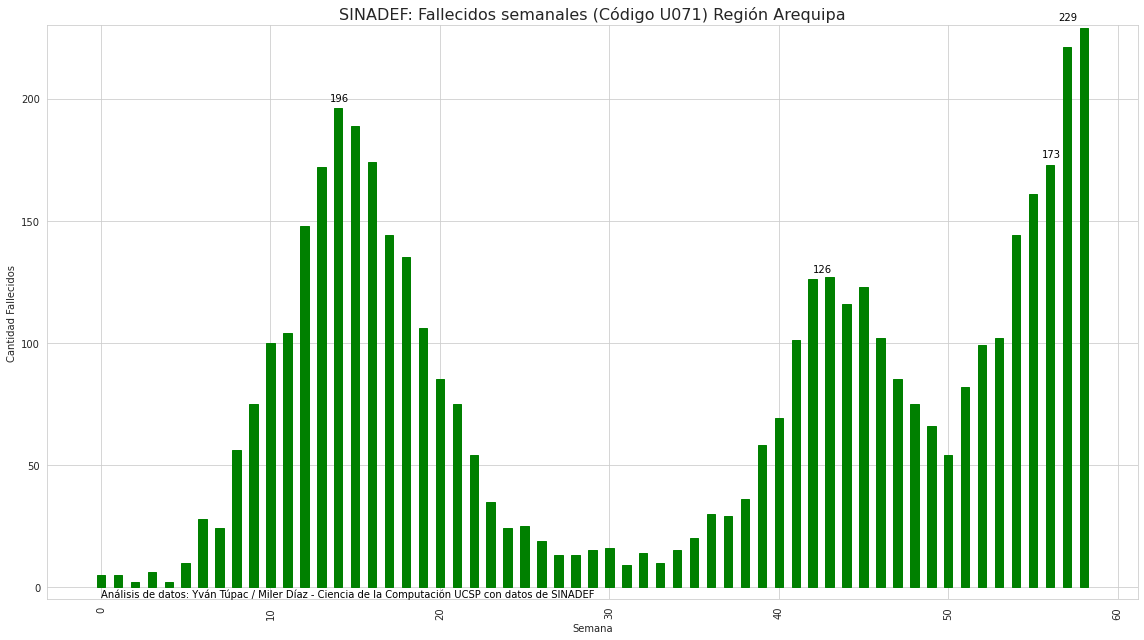

In [35]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(16,9))

ax1.bar(datos_sinadef_no_violenta_arequipa_covid_semanal.index,datos_sinadef_no_violenta_arequipa_covid_semanal['Nº'],color='g',edgecolor='g',width=0.5,label='Fallecidos semanales')
#sns.lineplot(data=datos_sinadef_no_violenta_arequipa_covid_semanal, x = 'AÑOSEMANA', y = 'Nº', ax=ax1)
ax1.set_ylim(-5,230)

# Add anottations to the plot
style = dict(size=10, color='k')
ax1.text(0,-4, "Análisis de datos: Yván Túpac / Miler Díaz - Ciencia de la Computación UCSP con datos de SINADEF", **style)
ax1.text(13.5, 196+3, 196, **style)
ax1.text(42, 126+3, 126, **style)
ax1.text(55.5, 173+3, 173, **style)
ax1.text(56.5, datos_sinadef_no_violenta_arequipa_covid_semanal.tail(1)['Nº']+3, str(int(datos_sinadef_no_violenta_arequipa_covid_semanal.tail(1)['Nº'])), **style)

#ax1.text(53, datos_sinadef_no_violenta_arequipa_covid_semanal.tail(1)['Nº']+10, datos_sinadef_no_violenta_arequipa_covid_semanal.tail(1)['Nº'], **style)

plt.xlabel('Semana')
plt.ylabel('Cantidad Fallecidos')
plt.xticks(rotation=90)
plt.title("SINADEF: Fallecidos semanales (Código U071) Región Arequipa",fontsize=16)
fig.tight_layout()
plt.savefig('SINADEF_COVID-19_Semanal_Arequipa.pdf')
plt.show()

In [36]:
datos_sinadef_no_violenta_arequipa_covid_diaria = datos_sinadef_no_violenta_arequipa_covid.groupby(['FECHA'])['Nº'].count()
datos_sinadef_no_violenta_arequipa_covid_diaria = datos_sinadef_no_violenta_arequipa_covid_diaria.to_frame().reset_index()

#datos_sinadef_no_violenta_arequipa_covid_provincias = datos_sinadef_no_violenta_arequipa_covid.groupby(['FECHA','PROVINCIA DOMICILIO'])['Nº'].count()
#datos_sinadef_no_violenta_arequipa_covid_provincias = datos_sinadef_no_violenta_arequipa_covid_provincias.to_frame().reset_index()
#datos_sinadef_no_violenta_arequipa_covid_provincias.sort_values(['FECHA','PROVINCIA DOMICILIO'])
#datos_sinadef_no_violenta_arequipa_covid_provincias.tail(20)


datos_sinadef_no_violenta_arequipa_covid_provincias1 = datos_sinadef_no_violenta_arequipa_covid.pivot_table(index=['FECHA'], columns=['PROVINCIA DOMICILIO'], values='Nº', aggfunc=len).fillna(0)
datos_sinadef_no_violenta_arequipa_covid_provincias1 = datos_sinadef_no_violenta_arequipa_covid_provincias1.reset_index()
datos_sinadef_no_violenta_arequipa_covid_provincias1['FECHA'] = pd.to_datetime(datos_sinadef_no_violenta_arequipa_covid_provincias1['FECHA'])
datos_sinadef_no_violenta_arequipa_covid_provincias1 = datos_sinadef_no_violenta_arequipa_covid_provincias1.set_index(['FECHA'])
datos_sinadef_no_violenta_arequipa_covid_provincias1.sum()

PROVINCIA DOMICILIO
AREQUIPA      3498.0
CAMANA         268.0
CARAVELI       138.0
CASTILLA        98.0
CAYLLOMA       226.0
CONDESUYOS      34.0
ISLAY          254.0
LA UNION        15.0
dtype: float64

In [37]:
datos_sinadef_no_violenta_arequipa_covid_provincias1.tail(5)

PROVINCIA DOMICILIO  AREQUIPA  CAMANA  CARAVELI  ...  CONDESUYOS  ISLAY  LA UNION
FECHA                                            ...                             
2021-05-26               26.0     1.0       1.0  ...         2.0    3.0       0.0
2021-05-27               30.0     1.0       1.0  ...         1.0    3.0       0.0
2021-05-28               25.0     1.0       1.0  ...         0.0    1.0       0.0
2021-05-29               25.0     1.0       1.0  ...         0.0    2.0       0.0
2021-05-30               22.0     1.0       0.0  ...         0.0    1.0       0.0

[5 rows x 8 columns]

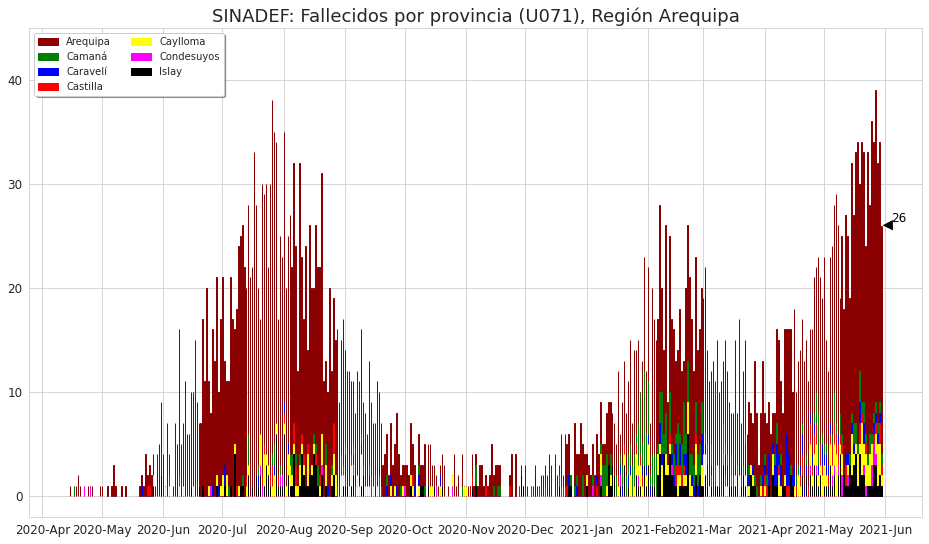

<Figure size 432x288 with 0 Axes>

In [38]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
barWidth = 0.25
colorsTable = ['darkred','green','blue','red','yellow','magenta','black','brown']

datos_sinadef_no_violenta_arequipa_covid_provincias1['acum_islay'] = datos_sinadef_no_violenta_arequipa_covid_provincias1['ISLAY'] + datos_sinadef_no_violenta_arequipa_covid_provincias1['LA UNION'] 
datos_sinadef_no_violenta_arequipa_covid_provincias1['acum_condesuyos'] = datos_sinadef_no_violenta_arequipa_covid_provincias1['CONDESUYOS'] + datos_sinadef_no_violenta_arequipa_covid_provincias1['acum_islay'] 
datos_sinadef_no_violenta_arequipa_covid_provincias1['acum_caylloma'] = datos_sinadef_no_violenta_arequipa_covid_provincias1['CAYLLOMA'] + datos_sinadef_no_violenta_arequipa_covid_provincias1['acum_condesuyos'] 
datos_sinadef_no_violenta_arequipa_covid_provincias1['acum_castilla'] = datos_sinadef_no_violenta_arequipa_covid_provincias1['CASTILLA'] + datos_sinadef_no_violenta_arequipa_covid_provincias1['acum_caylloma'] 
datos_sinadef_no_violenta_arequipa_covid_provincias1['acum_caraveli'] = datos_sinadef_no_violenta_arequipa_covid_provincias1['CARAVELI'] + datos_sinadef_no_violenta_arequipa_covid_provincias1['acum_castilla'] 
datos_sinadef_no_violenta_arequipa_covid_provincias1['acum_camana'] = datos_sinadef_no_violenta_arequipa_covid_provincias1['CAMANA'] + datos_sinadef_no_violenta_arequipa_covid_provincias1['acum_caraveli'] 
datos_sinadef_no_violenta_arequipa_covid_provincias1['acum_arequipa'] = datos_sinadef_no_violenta_arequipa_covid_provincias1['AREQUIPA'] + datos_sinadef_no_violenta_arequipa_covid_provincias1['acum_camana'] 

ax1.bar(datos_sinadef_no_violenta_arequipa_covid_provincias1.index,datos_sinadef_no_violenta_arequipa_covid_provincias1['acum_arequipa'],color=colorsTable[0],edgecolor=colorsTable[0],width = barWidth,label='Arequipa')
ax1.bar(datos_sinadef_no_violenta_arequipa_covid_provincias1.index,datos_sinadef_no_violenta_arequipa_covid_provincias1['acum_camana'],color=colorsTable[1],edgecolor=colorsTable[1],width = barWidth,label='Camaná')
ax1.bar(datos_sinadef_no_violenta_arequipa_covid_provincias1.index,datos_sinadef_no_violenta_arequipa_covid_provincias1['acum_caraveli'],color=colorsTable[2],edgecolor=colorsTable[2],width = barWidth,label='Caravelí')
ax1.bar(datos_sinadef_no_violenta_arequipa_covid_provincias1.index,datos_sinadef_no_violenta_arequipa_covid_provincias1['acum_castilla'],color=colorsTable[3],edgecolor=colorsTable[3],width = barWidth,label='Castilla')
ax1.bar(datos_sinadef_no_violenta_arequipa_covid_provincias1.index,datos_sinadef_no_violenta_arequipa_covid_provincias1['acum_caylloma'],color=colorsTable[4],edgecolor=colorsTable[4],width = barWidth,label='Caylloma')
ax1.bar(datos_sinadef_no_violenta_arequipa_covid_provincias1.index,datos_sinadef_no_violenta_arequipa_covid_provincias1['acum_condesuyos'],color=colorsTable[5],edgecolor=colorsTable[5],width = barWidth,label='Condesuyos')
ax1.bar(datos_sinadef_no_violenta_arequipa_covid_provincias1.index,datos_sinadef_no_violenta_arequipa_covid_provincias1['acum_islay'],color=colorsTable[6],edgecolor=colorsTable[6],width = barWidth,label='Islay')

ax1.legend(fancybox=True, shadow=True, ncol=2,fontsize=10)
ax1.xaxis_date()
#fig.tight_layout()
ax1.tick_params(labelsize=12)
#ax1.set_xlim([pd.to_datetime('2020-05-02'),None])
#ax1.set_xlim([pd.to_datetime('2021-01-01'),None])
ax1.set_ylim(-2,45)
#ax1.set_xlim(pd.to_datetime('2021-01-01'))

ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
date_form = DateFormatter("%Y-%b")
ax1.xaxis.set_major_formatter(date_form)


ax1.annotate(str(int(datos_sinadef_no_violenta_arequipa_covid_provincias1['acum_arequipa'].tail(1))), xy=(pd.to_datetime(dia_sinadef), datos_sinadef_no_violenta_arequipa_covid_provincias1['acum_arequipa'].tail(1)),  xycoords='data',
            xytext=(pd.to_datetime('2021-06-04'), datos_sinadef_no_violenta_arequipa_covid_provincias1['acum_arequipa'].tail(1)+0.3), textcoords='data',color='k',arrowprops=dict(facecolor='k', shrink=0.01),fontsize=12)

plt.title('SINADEF: Fallecidos por provincia (U071), Región Arequipa',fontsize=18)
#plt.savefig('image_12.png')
plt.savefig('SINADEF_COVID-19_Arequipa-Provincias.pdf')
plt.show()
plt.clf()

#sns.lineplot(data=datos_sinadef_no_violenta_arequipa_covid_provincias, x = 'FECHA', y = 'Nº', hue='PROVINCIA DOMICILIO', color='r',ax=ax1)
#sns.lineplot(data=datos_sinadef_semana, x = 'SEMANA', y = 'Nº', color='r',ax=ax1)


In [39]:
datos_sinadef_no_violenta_arequipa_covid_diaria = datos_sinadef_no_violenta_arequipa_covid.groupby(['FECHA'])['Nº'].count()
datos_sinadef_no_violenta_arequipa_covid_diaria = datos_sinadef_no_violenta_arequipa_covid_diaria.to_frame().reset_index()
datos_sinadef_no_violenta_arequipa_covid_diaria['PromFallecidos'] = datos_sinadef_no_violenta_arequipa_covid_diaria['Nº'].rolling(window=7).mean() 
#datos_sinadef_no_violenta_arequipa_covid_diaria.tail(10)


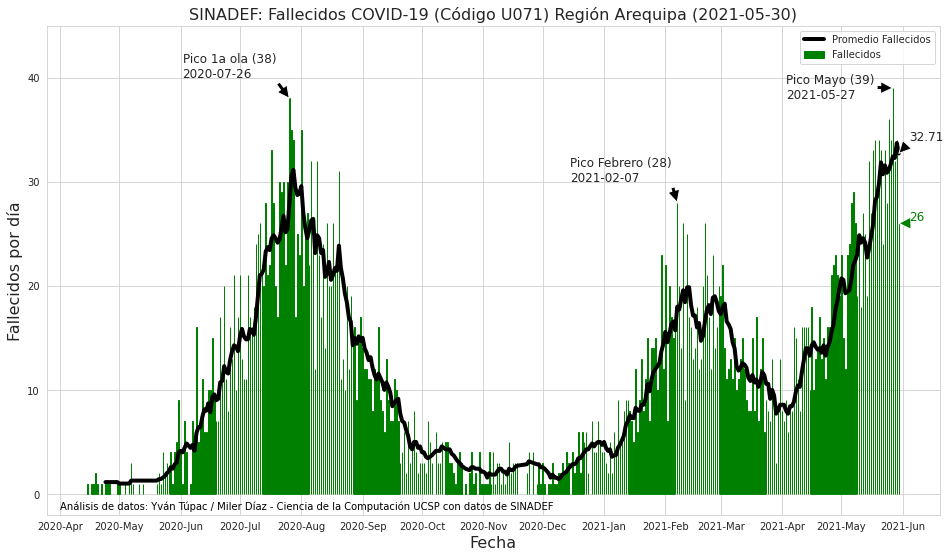

In [40]:
datos_sinadef_no_violenta_arequipa_covid_diaria_aux1 = datos_sinadef_no_violenta_arequipa_covid_diaria
datos_sinadef_no_violenta_arequipa_covid_diaria_aux1['FECHA'] = pd.to_datetime(datos_sinadef_no_violenta_arequipa_covid_diaria_aux1['FECHA'])
datos_sinadef_no_violenta_arequipa_covid_diaria_aux1 = datos_sinadef_no_violenta_arequipa_covid_diaria_aux1.set_index('FECHA')
#datos_sinadef_no_violenta_arequipa_covid_diaria_aux1.tail(7)
datos_sinadef_no_violenta_arequipa_covid_diaria_aux1.to_csv('SINADEF_COVID-19_Arequipa.csv')

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
barWidth = 0.25
ax1.bar(datos_sinadef_no_violenta_arequipa_covid_diaria_aux1.index,datos_sinadef_no_violenta_arequipa_covid_diaria_aux1['Nº'],color='g',edgecolor='g',width=barWidth,label='Fallecidos')

sns.lineplot(data=datos_sinadef_no_violenta_arequipa_covid_diaria_aux1, x=datos_sinadef_no_violenta_arequipa_covid_diaria_aux1.index, y="PromFallecidos", label='Promedio Fallecidos',  ax=ax1,color='k',linewidth=4.0)
#sns.lineplot(data=datos_sinadef_no_violenta_arequipa_covid_diaria_aux1, x=datos_sinadef_no_violenta_arequipa_covid_diaria_aux1.index, y="P_Arequipa", label='Fallecidos Prov Arequipa',  ax=ax1,color='b',linewidth=2.0)
#sns.lineplot(data=datos_sinadef_no_violenta_arequipa_covid_diaria_aux1, x=datos_sinadef_no_violenta_arequipa_covid_diaria_aux1.index, y="P_Islay", label='Fallecidos Prov Islay',  ax=ax1,color='maroon',linewidth=2.0)

ax1.set_ylabel('Fallecidos por día', fontsize=16)
ax1.set_xlabel('Fecha', fontsize=16)
ax1.set_ylim(-2,45)

# Format dates in xAxis
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
date_form = DateFormatter("%Y-%b")
ax1.xaxis.set_major_formatter(date_form)

# Add anottations to the plot
style = dict(size=10, color='k')
ax1.text(pd.to_datetime('2020-04-01'), -1.5, "Análisis de datos: Yván Túpac / Miler Díaz - Ciencia de la Computación UCSP con datos de SINADEF", **style)
ax1.annotate("Pico 1a ola (38)\n2020-07-26", xy=(pd.to_datetime('2020-7-26'), 38),  xycoords='data',
            xytext=(pd.to_datetime('2020-6-2'), 40), textcoords='data',arrowprops=dict(facecolor='black', shrink=0.01),fontsize=12)
ax1.annotate("Pico Febrero (28)\n2021-02-07", xy=(pd.to_datetime('2021-02-07'), 28),  xycoords='data',
            xytext=(pd.to_datetime('2020-12-15'), 30), textcoords='data',arrowprops=dict(facecolor='black', shrink=0.01),fontsize=12)
ax1.annotate("Pico Mayo (39)\n2021-05-27", xy=(pd.to_datetime('2021-05-27'), 39),  xycoords='data',
            xytext=(pd.to_datetime('2021-04-03'), 38), textcoords='data',arrowprops=dict(facecolor='black', shrink=0.01),fontsize=12)


lastDailyDead  = str(int(datos_sinadef_no_violenta_arequipa_covid_diaria_aux1.tail(1)['Nº']))
lastAverageDead = str(round(float(datos_sinadef_no_violenta_arequipa_covid_diaria_aux1.tail(1)['PromFallecidos']),2))
ax1.annotate(lastDailyDead, xy=(pd.to_datetime(dia_sinadef), datos_sinadef_no_violenta_arequipa_covid_diaria_aux1.tail(1)['Nº']),  xycoords='data',
            xytext=(pd.to_datetime('2021-06-04'), datos_sinadef_no_violenta_arequipa_covid_diaria_aux1.tail(1)['Nº']+0.3), textcoords='data',color='green',arrowprops=dict(facecolor='green', shrink=0.01),fontsize=12)
ax1.annotate(lastAverageDead, xy=(pd.to_datetime(dia_sinadef), datos_sinadef_no_violenta_arequipa_covid_diaria_aux1.tail(1)['PromFallecidos']),  xycoords='data',
            xytext=(pd.to_datetime('2021-06-04'), datos_sinadef_no_violenta_arequipa_covid_diaria_aux1.tail(1)['PromFallecidos']+1.3), textcoords='data',arrowprops=dict(facecolor='black', shrink=0.01),fontsize=12)

plt.title('SINADEF: Fallecidos COVID-19 (Código U071) Región Arequipa (' + dia_sinadef + ')',fontsize=16)
plt.savefig('SINADEF_COVID-19_Arequipa.pdf')
plt.savefig('SINADEF_COVID-19_Arequipa.png')


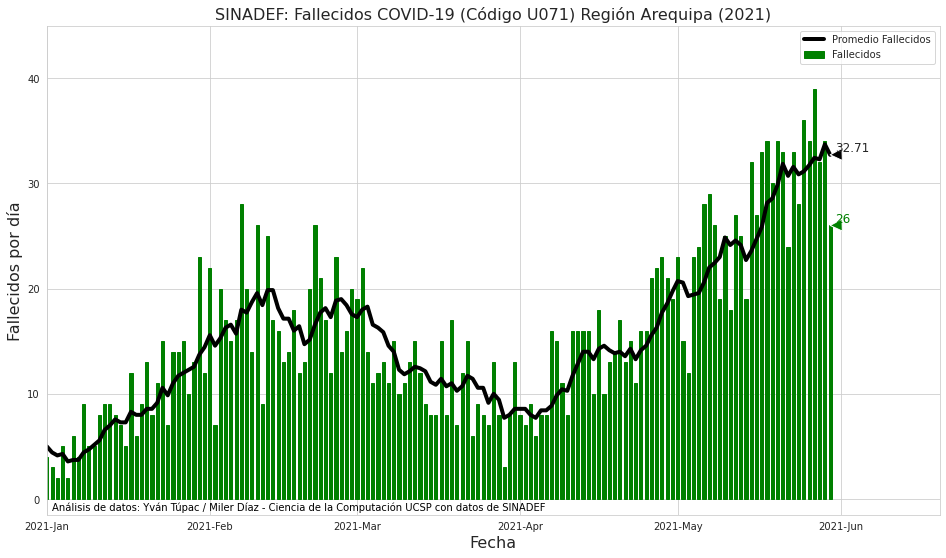

In [41]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
barWidth = 0.60
ax1.bar(datos_sinadef_no_violenta_arequipa_covid_diaria_aux1.index,datos_sinadef_no_violenta_arequipa_covid_diaria_aux1['Nº'],color='g',edgecolor='g',width=barWidth,label='Fallecidos')
sns.lineplot(data=datos_sinadef_no_violenta_arequipa_covid_diaria_aux1, x=datos_sinadef_no_violenta_arequipa_covid_diaria_aux1.index, y="PromFallecidos", label='Promedio Fallecidos',  ax=ax1,color='k',linewidth=4.0)
ax1.set_ylabel('Fallecidos por día', fontsize=16)
ax1.set_xlabel('Fecha', fontsize=16)
ax1.set_xlim(pd.to_datetime('2021-01-01'))
ax1.set_ylim(-1.5,45)

# Format dates in xAxis
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
date_form = DateFormatter("%Y-%b")
ax1.xaxis.set_major_formatter(date_form)
# Add anottations to the plot
style = dict(size=10, color='k')
ax1.text(pd.to_datetime('2021-01-02'), -1.10, "Análisis de datos: Yván Túpac / Miler Díaz - Ciencia de la Computación UCSP con datos de SINADEF", **style)
lastDailyDead  = str(int(datos_sinadef_no_violenta_arequipa_covid_diaria_aux1.tail(1)['Nº']))
lastAverageDead = str(round(float(datos_sinadef_no_violenta_arequipa_covid_diaria_aux1.tail(1)['PromFallecidos']),2))
ax1.annotate(lastDailyDead, xy=(pd.to_datetime(dia_sinadef), datos_sinadef_no_violenta_arequipa_covid_diaria_aux1.tail(1)['Nº']),  xycoords='data',
            xytext=(pd.to_datetime('2021-05-31'), datos_sinadef_no_violenta_arequipa_covid_diaria_aux1.tail(1)['Nº']+0.3), textcoords='data',color='green',arrowprops=dict(facecolor='green', shrink=0.01),fontsize=12)
ax1.annotate(lastAverageDead, xy=(pd.to_datetime(dia_sinadef), datos_sinadef_no_violenta_arequipa_covid_diaria_aux1.tail(1)['PromFallecidos']),  xycoords='data',
            xytext=(pd.to_datetime('2021-05-31'), datos_sinadef_no_violenta_arequipa_covid_diaria_aux1.tail(1)['PromFallecidos']+0.3), textcoords='data',arrowprops=dict(facecolor='black', shrink=0.01),fontsize=12)

plt.title('SINADEF: Fallecidos COVID-19 (Código U071) Región Arequipa (2021)',fontsize=16)
plt.savefig('SINADEF_COVID-19_Arequipa_2021.pdf')

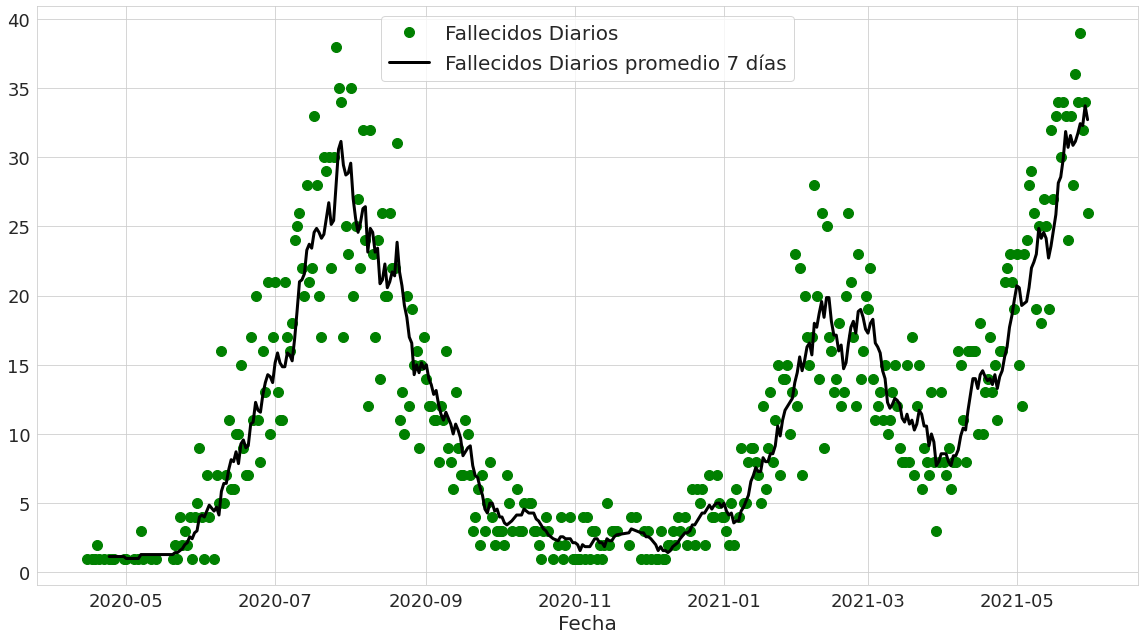

In [42]:
datos_sinadef_no_violenta_arequipa_covid_diaria_aux = datos_sinadef_no_violenta_arequipa_covid_diaria
datos_sinadef_no_violenta_arequipa_covid_diaria_aux['FECHA'] = pd.to_datetime(datos_sinadef_no_violenta_arequipa_covid_diaria_aux['FECHA'])
datos_sinadef_no_violenta_arequipa_covid_diaria_aux[''] = datos_sinadef_no_violenta_arequipa_covid.groupby(['FECHA'])['Nº'].count()


datos_sinadef_no_violenta_arequipa_covid_diaria_aux = datos_sinadef_no_violenta_arequipa_covid_diaria_aux.set_index('FECHA')

fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))

plots(ax1, 'line_plt', datos_sinadef_no_violenta_arequipa_covid_diaria_aux, 'Fecha', 'Fallecidos Diarios', 'Nº')
 
fig.tight_layout()
plt.show()

## COVID por lugar de fallecimiento

In [43]:
datos_no_violenta_AQP_covid_lugar = datos_sinadef_no_violenta_arequipa_covid.pivot_table(index=['FECHA'], columns=['TIPO LUGAR'], values='Nº', aggfunc=len).fillna(0)
datos_lugar_aux = pd.DataFrame(datos_no_violenta_AQP_covid_lugar, columns = ['CENTRO LABORAL','DOMICILIO','EESS','EN TRANSITO','IGNORADO','OTRO','VIA PUBLICA']) 
datos_lugar_aux = datos_lugar_aux.reset_index()
datos_lugar_aux['FECHA'] = pd.to_datetime(datos_lugar_aux['FECHA'])
datos_lugar_aux = datos_lugar_aux.set_index(['FECHA'])
datos_lugar_aux.sum()

CENTRO LABORAL       1.0
DOMICILIO          318.0
EESS              4162.0
EN TRANSITO         10.0
IGNORADO             3.0
OTRO                36.0
VIA PUBLICA          1.0
dtype: float64

In [44]:
datos_lugar_aux.tail(5)

CENTRO LABORAL  DOMICILIO  EESS  ...  IGNORADO  OTRO  VIA PUBLICA
FECHA                                        ...                             
2021-05-26             0.0        1.0  33.0  ...       0.0   0.0          0.0
2021-05-27             0.0        4.0  35.0  ...       0.0   0.0          0.0
2021-05-28             0.0        6.0  26.0  ...       0.0   0.0          0.0
2021-05-29             0.0        4.0  30.0  ...       0.0   0.0          0.0
2021-05-30             0.0        2.0  24.0  ...       0.0   0.0          0.0

[5 rows x 7 columns]

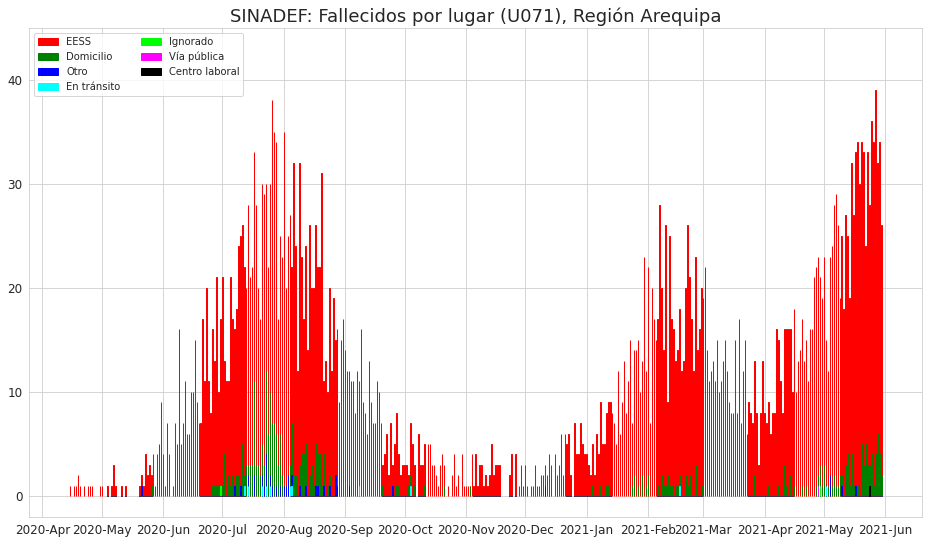

<Figure size 432x288 with 0 Axes>

In [45]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
barWidth = 0.25

colorsTable = ['red','green','blue','cyan','lime','magenta','black','brown']

# Axis date format
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
date_form = DateFormatter("%Y-%b")
ax1.xaxis.set_major_formatter(date_form)
ax1.set_ylim(-2,45)

datos_lugar_aux['acum_viapub'] = datos_lugar_aux['VIA PUBLICA'] + datos_lugar_aux['CENTRO LABORAL'] 
datos_lugar_aux['acum_ignorado'] = datos_lugar_aux['acum_viapub'] + datos_lugar_aux['IGNORADO']
datos_lugar_aux['acum_enTransito'] = datos_lugar_aux['acum_ignorado'] + datos_lugar_aux['EN TRANSITO']
datos_lugar_aux['acum_Otro'] = datos_lugar_aux['acum_enTransito'] + datos_lugar_aux['OTRO']
datos_lugar_aux['acum_Domicilio'] = datos_lugar_aux['acum_Otro'] + datos_lugar_aux['DOMICILIO']
datos_lugar_aux['acum_EESS'] = datos_lugar_aux['acum_Domicilio'] + datos_lugar_aux['EESS']

ax1.bar(datos_lugar_aux.index,datos_lugar_aux['acum_EESS'],color=colorsTable[0],edgecolor=colorsTable[0],width = barWidth,label='EESS')
ax1.bar(datos_lugar_aux.index,datos_lugar_aux['acum_Domicilio'],color=colorsTable[1],edgecolor=colorsTable[1],width = barWidth,label='Domicilio')
ax1.bar(datos_lugar_aux.index,datos_lugar_aux['acum_Otro'],color=colorsTable[2],edgecolor=colorsTable[2],width = barWidth,label='Otro')
ax1.bar(datos_lugar_aux.index,datos_lugar_aux['acum_enTransito'],color=colorsTable[3],edgecolor=colorsTable[3],width = barWidth,label='En tránsito')
ax1.bar(datos_lugar_aux.index,datos_lugar_aux['acum_ignorado'],color=colorsTable[4],edgecolor=colorsTable[4],width = barWidth,label='Ignorado')
ax1.bar(datos_lugar_aux.index,datos_lugar_aux['acum_viapub'],color=colorsTable[5],edgecolor=colorsTable[5],width = barWidth,label='Vía pública')
ax1.bar(datos_lugar_aux.index,datos_lugar_aux['CENTRO LABORAL'],color=colorsTable[6],edgecolor=colorsTable[6],width = barWidth,label='Centro laboral')

ax1.legend(fancybox=True, shadow=False, ncol=2,fontsize=10)
ax1.xaxis_date()
ax1.tick_params(labelsize=12)

#fig.tight_layout()

#ax1.set_xlim([pd.to_datetime('2020-05-02'),None])
#ax1.set_xlim([pd.to_datetime('2021-01-01'),None])
#ax1.set_xlim(pd.to_datetime('2021-01-01'))


plt.title('SINADEF: Fallecidos por lugar (U071), Región Arequipa',fontsize=18)
#plt.savefig('image_12.png')
plt.savefig('SINADEF_COVID-19_Arequipa-lugar.pdf')
plt.show()
plt.clf()

## Fallecidos por sexo

In [46]:
datos_no_violenta_AQP_covid_sexo = datos_sinadef_no_violenta_arequipa_covid.pivot_table(index=['FECHA'], columns=['SEXO'], values='Nº', aggfunc=len).fillna(0)
datos_lugar_aux = pd.DataFrame(datos_no_violenta_AQP_covid_lugar, columns = ['CENTRO LABORAL','DOMICILIO','EESS','EN TRANSITO','IGNORADO','OTRO','VIA PUBLICA']) 
datos_no_violenta_AQP_covid_sexo = datos_no_violenta_AQP_covid_sexo.reset_index()
datos_no_violenta_AQP_covid_sexo['FECHA'] = pd.to_datetime(datos_no_violenta_AQP_covid_sexo['FECHA'])
datos_no_violenta_AQP_covid_sexo = datos_no_violenta_AQP_covid_sexo.set_index(['FECHA'])
datos_no_violenta_AQP_covid_sexo.tail()

SEXO        FEMENINO  MASCULINO
FECHA                          
2021-05-26      16.0       18.0
2021-05-27      16.0       23.0
2021-05-28      20.0       12.0
2021-05-29      10.0       24.0
2021-05-30      12.0       14.0

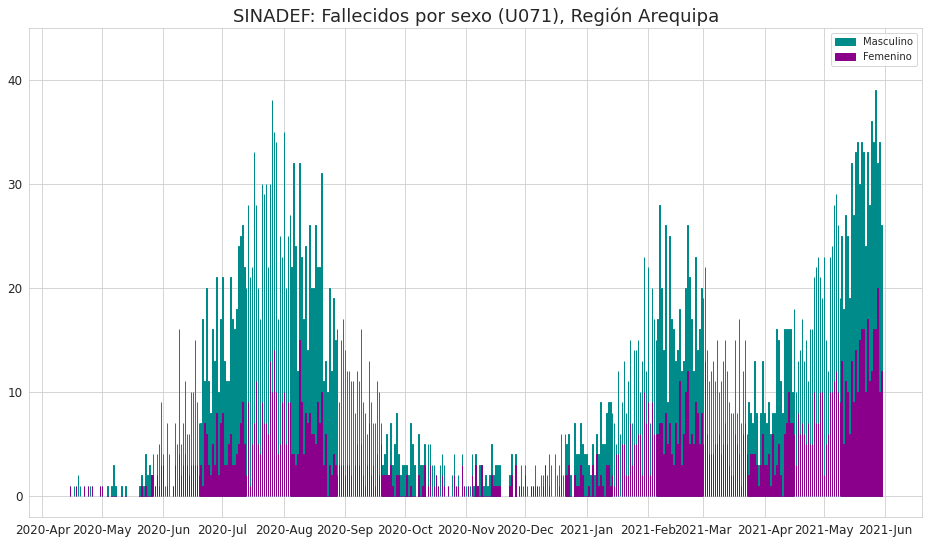

<Figure size 432x288 with 0 Axes>

In [47]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
barWidth = 0.25

colorsTable = ['darkcyan','darkmagenta','blue','cyan','lime','magenta','black','brown']

# Axis date format
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
date_form = DateFormatter("%Y-%b")
ax1.xaxis.set_major_formatter(date_form)
ax1.set_ylim(-2,45)

datos_no_violenta_AQP_covid_sexo['acum_masculino'] = datos_no_violenta_AQP_covid_sexo['MASCULINO'] + datos_no_violenta_AQP_covid_sexo['FEMENINO'] 

ax1.bar(datos_no_violenta_AQP_covid_sexo.index,datos_no_violenta_AQP_covid_sexo['acum_masculino'],color=colorsTable[0],edgecolor=colorsTable[0],width = barWidth,label='Masculino')
ax1.bar(datos_no_violenta_AQP_covid_sexo.index,datos_no_violenta_AQP_covid_sexo['FEMENINO'],color=colorsTable[1],edgecolor=colorsTable[1],width = barWidth,label='Femenino')

ax1.legend(fancybox=True, shadow=False, ncol=1,fontsize=10)
ax1.xaxis_date()
ax1.tick_params(labelsize=12)

#fig.tight_layout()

#ax1.set_xlim([pd.to_datetime('2020-05-02'),None])
#ax1.set_xlim([pd.to_datetime('2021-01-01'),None])
#ax1.set_xlim(pd.to_datetime('2021-01-01'))


plt.title('SINADEF: Fallecidos por sexo (U071), Región Arequipa',fontsize=18)
#plt.savefig('image_12.png')
plt.savefig('SINADEF_COVID-19_Arequipa-sexo.pdf')
plt.show()
plt.clf()

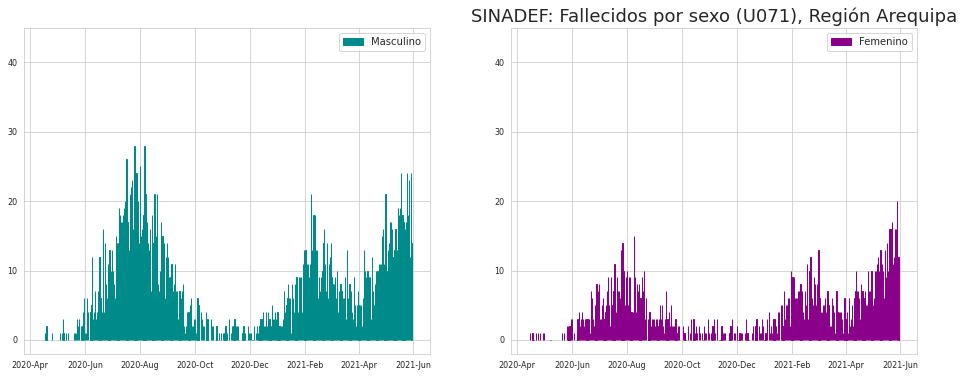

<Figure size 432x288 with 0 Axes>

In [48]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
barWidth = 0.25

colorsTable = ['darkcyan','darkmagenta','blue','cyan','lime','magenta','black','brown']

# Axis date format
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
date_form = DateFormatter("%Y-%b")
ax1.xaxis.set_major_formatter(date_form)

ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
#date_form = DateFormatter("%Y-%b")
ax2.xaxis.set_major_formatter(date_form)


ax1.set_ylim(-2,45)
ax2.set_ylim(-2,45)

#datos_no_violenta_AQP_covid_sexo['acum_masculino'] = datos_no_violenta_AQP_covid_sexo['MASCULINO'] + datos_no_violenta_AQP_covid_sexo['FEMENINO'] 

ax1.bar(datos_no_violenta_AQP_covid_sexo.index,datos_no_violenta_AQP_covid_sexo['MASCULINO'],color=colorsTable[0],edgecolor=colorsTable[0],width = barWidth,label='Masculino')
ax2.bar(datos_no_violenta_AQP_covid_sexo.index,datos_no_violenta_AQP_covid_sexo['FEMENINO'],color=colorsTable[1],edgecolor=colorsTable[1],width = barWidth,label='Femenino')

ax1.legend(fancybox=True, shadow=False, ncol=1,fontsize=10)
ax2.legend(fancybox=True, shadow=False, ncol=1,fontsize=10)
ax1.xaxis_date()
ax1.tick_params(labelsize=8)
ax2.xaxis_date()
ax2.tick_params(labelsize=8)



#fig.tight_layout()

#ax1.set_xlim([pd.to_datetime('2020-05-02'),None])
#ax1.set_xlim([pd.to_datetime('2021-01-01'),None])
#ax1.set_xlim(pd.to_datetime('2021-01-01'))


plt.title('SINADEF: Fallecidos por sexo (U071), Región Arequipa',fontsize=18)
#plt.savefig('image_12.png')
plt.savefig('SINADEF_COVID-19_Arequipa-sexosep.pdf')
plt.show()
plt.clf()

# Clustering datos No Violentos Arequipa

Reference: https://www.kaggle.com/maksimeren/covid-19-literature-clustering

In [ ]:
datos_sinadef_arequipa_clustering_sample = datos_sinadef_no_violenta[(datos_sinadef_no_violenta['FECHA'] >= '2020-01-01') & \
                                                                     (datos_sinadef_no_violenta['DEPARTAMENTO DOMICILIO'] == 'AREQUIPA')]

## Initialize

In [ ]:
# Download the spacy bio parser
from IPython.utils import io
with io.capture_output() as captured:
    !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz
    !pip install stop-words

#NLP 
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_sci_lg  # model downloaded in previous step
import string

from stop_words import get_stop_words

from tqdm import tqdm
tqdm.pandas()

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans

from sklearn import metrics
from scipy.spatial.distance import cdist

from sklearn.manifold import TSNE

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [ ]:
stop_words = get_stop_words('spanish')
punctuations = string.punctuation

# Parser
parser = en_core_sci_lg.load(disable=["tagger", "ner"])
parser.max_length = 7000000

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    #mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word.lemma_.lower().strip() for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

def vectorize(text, maxx_features):
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

## Pre-processing

In [ ]:
datos_sinadef_arequipa_clustering_sample = datos_sinadef_arequipa_clustering_sample.replace('SIN REGISTRO', ' ')

datos_sinadef_arequipa_clustering_sample = datos_sinadef_arequipa_clustering_sample[['DEBIDO A (CAUSA A)',
                                                                                     'CAUSA A (CIE-X)',
                                                                                     'DEBIDO A (CAUSA B)',
                                                                                     'CAUSA B (CIE-X)',
                                                                                     'DEBIDO A (CAUSA C)',
                                                                                     'CAUSA C (CIE-X)',
                                                                                     'DEBIDO A (CAUSA D)',
                                                                                     'CAUSA D (CIE-X)',
                                                                                     'DEBIDO A (CAUSA E)',
                                                                                     'CAUSA E (CIE-X)',
                                                                                     'DEBIDO A (CAUSA F)',
                                                                                     'CAUSA F (CIE-X)']]

datos_sinadef_arequipa_clustering_sample['all_features'] =  datos_sinadef_arequipa_clustering_sample['DEBIDO A (CAUSA A)'] + ' ' + \
                                                            datos_sinadef_arequipa_clustering_sample['CAUSA A (CIE-X)'] + ' ' + \
                                                            datos_sinadef_arequipa_clustering_sample['DEBIDO A (CAUSA B)'] + ' ' + \
                                                            datos_sinadef_arequipa_clustering_sample['CAUSA B (CIE-X)'] + ' ' + \
                                                            datos_sinadef_arequipa_clustering_sample['DEBIDO A (CAUSA C)'] + ' ' + \
                                                            datos_sinadef_arequipa_clustering_sample['CAUSA C (CIE-X)'] + ' ' + \
                                                            datos_sinadef_arequipa_clustering_sample['DEBIDO A (CAUSA D)'] + ' ' + \
                                                            datos_sinadef_arequipa_clustering_sample['CAUSA D (CIE-X)'] + ' ' + \
                                                            datos_sinadef_arequipa_clustering_sample['DEBIDO A (CAUSA E)'] + ' ' + \
                                                            datos_sinadef_arequipa_clustering_sample['CAUSA E (CIE-X)'] + ' ' + \
                                                            datos_sinadef_arequipa_clustering_sample['DEBIDO A (CAUSA F)'] + ' ' + \
                                                            datos_sinadef_arequipa_clustering_sample['CAUSA F (CIE-X)']

datos_sinadef_arequipa_clustering_sample

DEBIDO A (CAUSA A)  ...                                       all_features
52                          TRAUMATISMO ENCEFALO CRANEANO  ...  TRAUMATISMO ENCEFALO CRANEANO S069 AHOGAMIENTO...
61                                  NEOPLASIA DE PANCREAS  ...        NEOPLASIA DE PANCREAS                      
170     IMPRECISABLE POR AVANZADO ESTADO DE DESCOMPOSI...  ...  IMPRECISABLE POR AVANZADO ESTADO DE DESCOMPOSI...
220                                        CHOQUE SEPTICO  ...  CHOQUE SEPTICO R572 BRONCONEUMONIA J180 ENFERM...
226                            INSUFICIENCIA RESPIRATORIA  ...  INSUFICIENCIA RESPIRATORIA   ENFERMEDAD DE MEM...
...                                                   ...  ...                                                ...
616482                         INSUFICIENCIA RESPIRATORIA  ...  INSUFICIENCIA RESPIRATORIA J960 NEUMONIA POR S...
616496                                          SENILIDAD  ...                 SENILIDAD R54X                    
616501            INSUFICIENCIA RESPIRATORIA AGUDA SEVERA  ...  INSUFICIENCIA RESPIRATORIA AGUDA SEVERA J969 C...
616513                                FALLA MULTIORGANICA  ...  FALLA MULTIORGANICA R688 NEOPLASIA DE RIÑON C6...
616525                   INSUFICIENCIA RESPIRATORIA AGUDA  ...  INSUFICIENCIA RESPIRATORIA AGUDA J960 NEUMONIA...

[14160 rows x 13 columns]

## Clean

In [ ]:
datos_sinadef_arequipa_clustering_sample["processed_text"] = datos_sinadef_arequipa_clustering_sample['all_features'].progress_apply(spacy_tokenizer)

100%|██████████| 14160/14160 [01:05<00:00, 215.33it/s]


## Vectorize

In [ ]:
text = datos_sinadef_arequipa_clustering_sample['processed_text'].values
X = vectorize(text, 2 ** 12)
X.shape

(14160, 4096)

## PCA

In [ ]:
pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

(14160, 1422)

## Elbow Method

In [ ]:
# run kmeans with many different k
"""
distortions = []
K = range(2, 50)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    print('Found distortion for {} clusters'.format(k))

X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.savefig('elbow_departamento_arequipa_2020.png')
plt.show()
"""

"\ndistortions = []\nK = range(2, 50)\nfor k in K:\n    k_means = KMeans(n_clusters=k, random_state=42).fit(X_reduced)\n    k_means.fit(X_reduced)\n    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])\n    print('Found distortion for {} clusters'.format(k))\n\nX_line = [K[0], K[-1]]\nY_line = [distortions[0], distortions[-1]]\n\n# Plot the elbow\nplt.plot(K, distortions, 'b-')\nplt.plot(X_line, Y_line, 'r')\nplt.xlabel('k')\nplt.ylabel('Distortion')\nplt.title('The Elbow Method showing the optimal k')\nplt.savefig('elbow_departamento_arequipa_2020.png')\nplt.show()\n"

## K-means over K calculated

In [ ]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
datos_sinadef_arequipa_clustering_sample['y'] = y_pred

## TSNE Method

In [ ]:
tsne = TSNE(verbose=1, perplexity=100, random_state=42)
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 14160 samples in 13.179s...
[t-SNE] Computed neighbors for 14160 samples in 1762.039s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14160
[t-SNE] Computed conditional probabilities for sample 2000 / 14160
[t-SNE] Computed conditional probabilities for sample 3000 / 14160
[t-SNE] Computed conditional probabilities for sample 4000 / 14160
[t-SNE] Computed conditional probabilities for sample 5000 / 14160
[t-SNE] Computed conditional probabilities for sample 6000 / 14160
[t-SNE] Computed conditional probabilities for sample 7000 / 14160
[t-SNE] Computed conditional probabilities for sample 8000 / 14160
[t-SNE] Computed conditional probabilities for sample 9000 / 14160
[t-SNE] Computed conditional probabilities for sample 10000 / 14160
[t-SNE] Computed conditional probabilities for sample 11000 / 14160
[t-SNE] Computed conditional probabilities for sample 12000 / 14160
[t-SNE] Computed conditional probabilities fo

## Plot Clusters

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


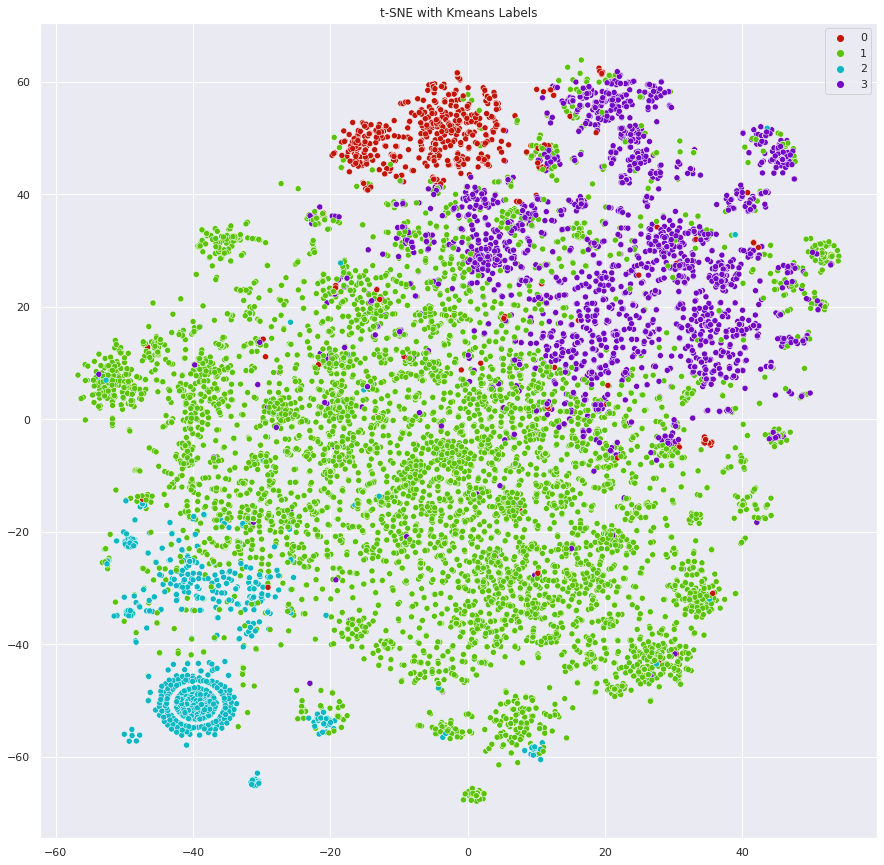

In [ ]:
# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.hls_palette(k, l=.4, s=.9)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("image_23.png")
plt.show()

## Topic Modeling

In [ ]:
vectorizers = []
    
for ii in range(0, k):
    # Creating a vectorizer
    vectorizers.append(CountVectorizer(min_df=5, max_df=0.9, stop_words=stop_words, lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))

vectorizers[0]

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=0.9, max_features=None, min_df=5,
                ngram_range=(1, 1), preprocessor=None,
                stop_words=['a', 'al', 'algo', 'algunas', 'algunos', 'ante',
                            'antes', 'como', 'con', 'contra', 'cual', 'cuando',
                            'de', 'del', 'desde', 'donde', 'durante', 'e', 'el',
                            'ella', 'ellas', 'ellos', 'en', 'entre', 'era',
                            'erais', 'eran', 'eras', 'eres', 'es', ...],
                strip_accents=None, token_pattern='[a-zA-Z\\-][a-zA-Z\\-]{2,}',
                tokenizer=None, vocabulary=None)

In [ ]:
vectorized_data = []

for current_cluster, cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(cvec.fit_transform(datos_sinadef_arequipa_clustering_sample.loc[datos_sinadef_arequipa_clustering_sample['y'] == current_cluster, 'processed_text']))
    except Exception as e:
        print("Not enough instances in cluster: " + str(current_cluster))
        vectorized_data.append(None)
        
len(vectorized_data)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ais', 'amos', 'bamos', 'est', 'estuvi', 'hab', 'habr', 'hubi', 'ramos', 'semos', 'ser', 'tambi', 'ten', 'tendr', 'teng', 'tuvi'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ais', 'amos', 'bamos', 'est', 'estuvi', 'hab', 'habr', 'hubi', 'ramos', 'semos', 'ser', 'tambi', 'ten', 'tendr', 'teng', 'tuvi'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ais', 'amos', 'bamos', 'est', 

4

In [ ]:
# number of topics per cluster
NUM_TOPICS_PER_CLUSTER = 10

lda_models = []
for ii in range(0, k):
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER, max_iter=10, learning_method='online',verbose=False, random_state=42)
    lda_models.append(lda)
    
lda_models[0]

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=False)

In [ ]:
clusters_lda_data = []

for current_cluster, lda in enumerate(lda_models):
    print("Current Cluster: " + str(current_cluster))
    
    if vectorized_data[current_cluster] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))

len(clusters_lda_data[0])

Current Cluster: 0
Current Cluster: 1
Current Cluster: 2
Current Cluster: 3


859

In [ ]:
all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_vectorizer))

    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))

display(all_keywords[2][:20])
len(all_keywords)

['choque',
 'cardiogenico',
 'multiorganica',
 'diabetes',
 'mellitus',
 'insuficiencia',
 'arterial',
 'respiratoria',
 'cardiopatia',
 'hipertension',
 'falla',
 'shock',
 'mellituns',
 'aguda',
 'paro',
 'cronica',
 'respiratorio',
 'cardio',
 'sepsis',
 'isquemica']

4

In [ ]:
f=open('topicos.txt','w')

count = 0

for ii in all_keywords:

    if vectorized_data[count] != None:
        f.write(', '.join(ii) + "\n")
    else:
        f.write("Not enough instances to be determined. \n")
        f.write(', '.join(ii) + "\n")
    count += 1

f.close()

## Verifying Topics

In [ ]:
ver_topico = 3
df = datos_sinadef_arequipa_clustering_sample[datos_sinadef_arequipa_clustering_sample['y'] == ver_topico]
display(df)

df.to_csv('df.csv')

df['processed_text'].to_csv('palabras_cluster_' + str(ver_topico) + '.txt', header=False, index=False)

from collections import Counter
results = Counter()
df['processed_text'].str.lower().str.split().apply(results.update)
print(results)

DEBIDO A (CAUSA A)  ...  y
3229                  INSUFICIENCIA RESPIRATORIA AGUDA  ...  3
6314                  INSUFICIENCIA RESPIRATORIA AGUDA  ...  3
7843                  INSUFICIENCIA RESPIRATORIA AGUDA  ...  3
9914                        INSUFICIENCIA RESPIRATORIA  ...  3
10770                       INSUFICIENCIA RESPIRATORIA  ...  3
...                                                ...  ... ..
616225  SINDROME DE DIFICULTAD RESPIRATORIA DEL ADULTO  ...  3
616279                INSUFICIENCIA RESPIRATORIA AGUDA  ...  3
616337                INSUFICIENCIA RESPIRATORIA AGUDA  ...  3
616387                INSUFICIENCIA RESPIRATORIA AGUDA  ...  3
616501         INSUFICIENCIA RESPIRATORIA AGUDA SEVERA  ...  3

[3514 rows x 15 columns]

Counter({'respiratoria': 3444, 'insuficiencia': 3107, 'covid': 2731, 'neumonia': 2322, 'j960': 2232, 'u071': 2221, '19': 2169, 'aguda': 1963, 'virus': 1049, 'identificado': 1041, 'u072': 961, 'viral': 723, 'j80x': 595, 'j129': 522, 'j969': 514, 'severa': 488, 'infeccion': 488, 'j189': 436, 'covid-19': 404, 'dificultad': 390, 'sindrome': 385, 'arterial': 315, 'i10x': 308, 'hipertension': 295, 'especificada': 289, 'atipica': 284, 'adulto': 266, 'diabetes': 251, 'j128': 247, 'mellitus': 245, 'obesidad': 221, 'covid19': 206, 'j22x': 201, 'falla': 191, 'coronavirus': 179, 'caso': 174, 'e669': 164, 'sospechoso': 156, 'infección': 130, 'renal': 127, 'neumonía': 123, 'multiorganica': 120, 'enfermedad': 106, 'shock': 106, 'confirmado': 105, 'respiratorio': 99, 'e119': 84, 'r579': 84, 'sepsis': 79, '2': 78, 'pulmonar': 77, 'a419': 71, 'j180': 68, 'síndrome': 67, 'n179': 65, 'b972': 64, 'septico': 63, 'j168': 60, 'j159': 59, 'r651': 55, 'tipo': 50, 'choque': 46, 'r572': 45, 'distres': 45, 'cronic

## Visualize only Covid-19 with topics

In [ ]:
datos_sinadef_arequipa_clustering_sample_2 = datos_sinadef_no_violenta[(datos_sinadef_no_violenta['FECHA'] >= '2020-01-01') & \
                                                                     (datos_sinadef_no_violenta['DEPARTAMENTO DOMICILIO'] == 'AREQUIPA')]
datos_sinadef_arequipa_clustering_sample_2['TOPICO'] = datos_sinadef_arequipa_clustering_sample['y']
datos_sinadef_arequipa_clustering_sample_2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Nº TIPO SEGURO       SEXO EDAD  ... AÑOSEMANA MESDIA  AÑO2 TOPICO
52          53         SIS   FEMENINO    2  ...    2020-3  01-15  2020      1
61          62     ESSALUD  MASCULINO   88  ...    2020-3  01-16  2020      1
170        171         SIS  MASCULINO   60  ...    2020-5  01-28  2020      1
220        221         SIS  MASCULINO   57  ...    2020-5  02-01  2020      1
226        227         SIS  MASCULINO    5  ...    2020-5  01-31  2020      1
...        ...         ...        ...  ...  ...       ...    ...   ...    ...
616482  616483         SIS  MASCULINO   61  ...   2021-10  03-01  2021      0
616496  616497    IGNORADO   FEMENINO   92  ...   2021-10  03-01  2021      1
616501  616502    IGNORADO   FEMENINO   82  ...   2021-10  03-01  2021      3
616513  616514    IGNORADO   FEMENINO   75  ...   2021-10  03-01  2021      1
616525  616526     ESSALUD   FEMENINO   78  ...   2021-10  03-01  2021      0

[14160 rows x 36 columns]

In [ ]:
datos_sinadef_arequipa_clustering_sample_2.to_csv('datos_sinadef_arequipa_clustering_sample_2.csv')
#datos_sinadef_arequipa_clustering_sample_2 = pd.read_csv('datos_sinadef_arequipa_clustering_sample_2.csv')
datos_sinadef_arequipa_clustering_sample_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14160 entries, 52 to 616525
Data columns (total 36 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Nº                      14160 non-null  int64 
 1   TIPO SEGURO             14160 non-null  object
 2   SEXO                    14160 non-null  object
 3   EDAD                    14160 non-null  object
 4   TIEMPO EDAD             14160 non-null  object
 5   ESTADO CIVIL            14160 non-null  object
 6   NIVEL DE INSTRUCCIÓN    14160 non-null  object
 7   COD# UBIGEO DOMICILIO   14160 non-null  object
 8   PAIS DOMICILIO          14160 non-null  object
 9   DEPARTAMENTO DOMICILIO  14160 non-null  object
 10  PROVINCIA DOMICILIO     14160 non-null  object
 11  DISTRITO DOMICILIO      14160 non-null  object
 12  FECHA                   14160 non-null  object
 13  AÑO                     14160 non-null  int64 
 14  MES                     14160 non-null  int64 
 15  

In [ ]:
datos_sinadef_arequipa_clustering_sample_3 = datos_sinadef_arequipa_clustering_sample_2[datos_sinadef_arequipa_clustering_sample_2['FECHA'] <= '2021-03-24' ]
datos_sinadef_arequipa_clustering_sample_3 = datos_sinadef_arequipa_clustering_sample_3[(datos_sinadef_arequipa_clustering_sample_3['TOPICO'] == 0) | (datos_sinadef_arequipa_clustering_sample_3['TOPICO'] == 3)]

datos_sinadef_arequipa_clustering_sample_3['SEMANA'] = datos_sinadef_arequipa_clustering_sample_3['SEMANA'].astype('str')
datos_sinadef_arequipa_clustering_sample_3['SEMANA'] = datos_sinadef_arequipa_clustering_sample_3['SEMANA'].apply(lambda x: '0'+x if len(x)==1 else x)
datos_sinadef_arequipa_clustering_sample_3['AÑOSEMANA'] = datos_sinadef_arequipa_clustering_sample_3['AÑO2'].astype('str') + '-' + datos_sinadef_arequipa_clustering_sample_3['SEMANA']

datos_sinadef_arequipa_clustering_sample_3.tail()

Nº TIPO SEGURO       SEXO EDAD  ... AÑOSEMANA MESDIA  AÑO2 TOPICO
616337  616338         SIS  MASCULINO   87  ...   2021-10  03-01  2021      3
616387  616388         SIS  MASCULINO   54  ...   2021-10  03-01  2021      3
616482  616483         SIS  MASCULINO   61  ...   2021-10  03-01  2021      0
616501  616502    IGNORADO   FEMENINO   82  ...   2021-10  03-01  2021      3
616525  616526     ESSALUD   FEMENINO   78  ...   2021-10  03-01  2021      0

[5 rows x 36 columns]

In [ ]:
datos_sinadef_arequipa_clustering_sample_3_semanal = datos_sinadef_arequipa_clustering_sample_3.groupby(['AÑOSEMANA'])['Nº'].count()
datos_sinadef_arequipa_clustering_sample_3_semanal = datos_sinadef_arequipa_clustering_sample_3_semanal.to_frame().reset_index()
datos_sinadef_arequipa_clustering_sample_3_semanal.tail()

AÑOSEMANA   Nº
54   2021-09  126
55   2021-10  106
56   2021-11   90
57   2021-12   78
58   2021-13   29

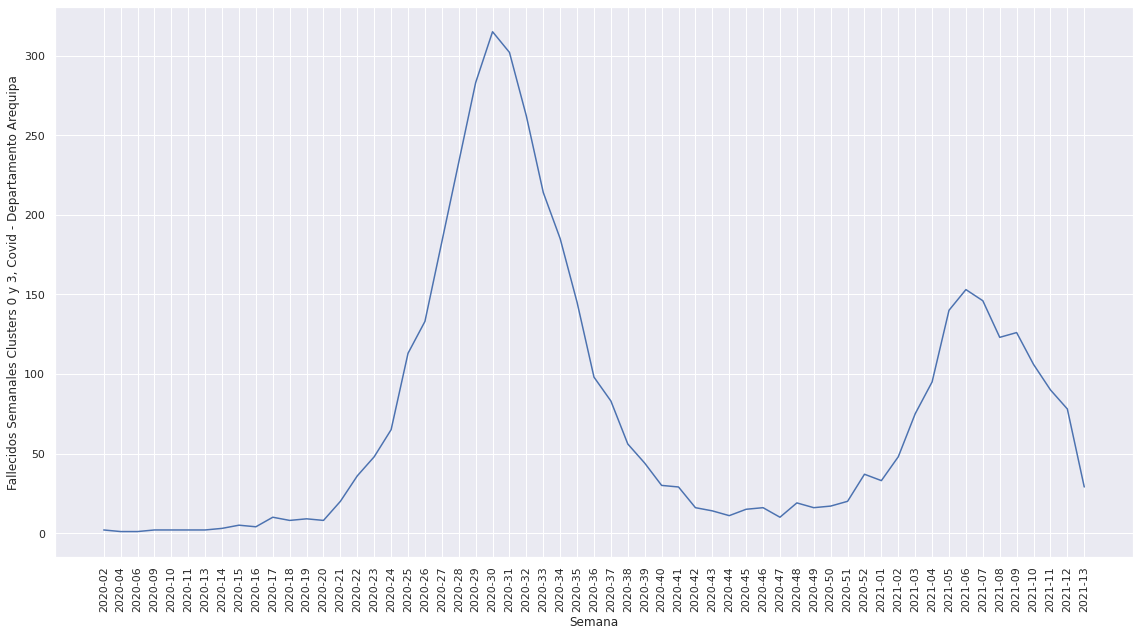

In [ ]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))

#sns.lineplot(data=datos_sinadef_arequipa_clustering_sample_3, x = 'SEMANA', y = 'Nº', hue='AÑO2', ax=ax1)
sns.lineplot(data=datos_sinadef_arequipa_clustering_sample_3_semanal, x = 'AÑOSEMANA', y = 'Nº', ax=ax1)

plt.xlabel('Semana')
plt.ylabel('Fallecidos Semanales Clusters 0 y 3, Covid - Departamento Arequipa')
plt.xticks(rotation=90)
fig.tight_layout()
plt.savefig('image_31.png')
plt.show()

In [ ]:
datos_sinadef_arequipa_clustering_sample_3_diaria = datos_sinadef_arequipa_clustering_sample_2.groupby(['FECHA'])['Nº'].count()
datos_sinadef_arequipa_clustering_sample_3_diaria = datos_sinadef_arequipa_clustering_sample_3_diaria.to_frame().reset_index()
datos_sinadef_arequipa_clustering_sample_3_diaria.tail()

FECHA  Nº
445  2021-03-21  28
446  2021-03-22  34
447  2021-03-23  31
448  2021-03-24  23
449  2021-03-25  29

In [ ]:
"""
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))

sns.lineplot(data=datos_sinadef_arequipa_clustering_sample_3_diaria, x = 'FECHA', y = 'Nº', ax=ax1)

plt.xlabel('Semana')
plt.ylabel('Fallecidos Diarios Clusters 0 y 3, Covid - Departamento Arequipa')
plt.xticks(rotation=90)
fig.tight_layout()

plt.show()
"""

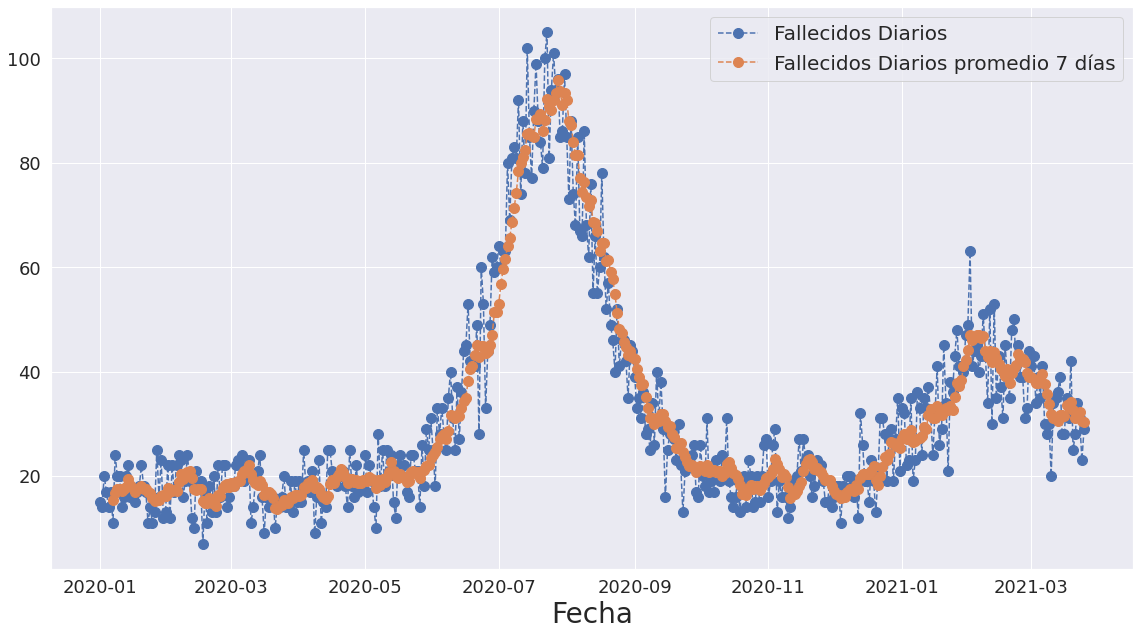

In [ ]:
datos_sinadef_arequipa_clustering_sample_3_diaria_aux = datos_sinadef_arequipa_clustering_sample_3_diaria
datos_sinadef_arequipa_clustering_sample_3_diaria_aux['FECHA'] = pd.to_datetime(datos_sinadef_arequipa_clustering_sample_3_diaria_aux['FECHA'])
datos_sinadef_arequipa_clustering_sample_3_diaria_aux = datos_sinadef_arequipa_clustering_sample_3_diaria.set_index('FECHA')

fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))

plots(ax1, 'line_plt', datos_sinadef_arequipa_clustering_sample_3_diaria_aux, 'Fecha', 'Fallecidos Diarios', 'Nº')
 
fig.tight_layout()
plt.show()

In [ ]:
from google.colab import files
for i in range(1,26):
    files.download('image_' + str(i) + '.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>